In [25]:
#Pablo Sebastián Herrera
#Juan Luis Solórzano
#Lab 1. Time Series Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import normaltest

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa as tsa
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


# funcion para colocar la serie de datos en formato matricial para la red

from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


# Carga de los datos

In [26]:
#lectura de datos
df_importaciones = pd.read_excel("Estadisticas.xlsx",sheet_name = "IMPORTACION")
df_importacionesPred = pd.read_excel("Estadisticas.xlsx",sheet_name = "Importaciones2025")

df_consumo = pd.read_excel("Estadisticas.xlsx",sheet_name = "CONSUMO")
df_consumoPred = pd.read_excel("Estadisticas.xlsx",sheet_name = "ONSUMO2025")

df_importaciones.columns

Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido',
       'Total importación'],
      dtype='object')

In [27]:
columns = ["Fecha", "Gasolina regular","Gasolina superior","Diesel alto azufre",]
importaciones = df_importaciones[columns].copy()
consumo = df_consumo[columns].copy()
consumoPred = df_consumoPred[["Fecha", "Gasolina regular","Gasolina superior"]].copy()
importacionesPred = df_importacionesPred[["Fecha", "Gasolina regular","Gasolina superior"]].copy()
importaciones.head(5)

Fecha  Gasolina regular  Gasolina superior  Diesel alto azufre
0 2001-01-01         177776.50          373963.96           566101.99
1 2001-02-01         123115.99          243091.07           489525.80
2 2001-03-01         161726.42          312084.38           575559.68
3 2001-04-01         127338.74          285054.89           437745.42
4 2001-05-01         168730.19          300913.67           552609.13

# Análisis Series Temporales

In [28]:
importaciones_regular_ts = importaciones[["Fecha", "Gasolina regular"]].copy()
importaciones_regular_ts.set_index('Fecha', inplace=True)
importaciones_super_ts = importaciones[["Fecha", "Gasolina superior"]].copy()
importaciones_super_ts.set_index('Fecha', inplace=True)
importaciones_diesel_ts = importaciones[["Fecha", "Diesel alto azufre"]].copy()
importaciones_diesel_ts.set_index('Fecha', inplace=True)

# pred es
importacionesPred_regular_ts = importacionesPred[["Fecha", "Gasolina regular"]].copy()
importacionesPred_regular_ts.set_index('Fecha', inplace=True)
importacionesPred_super_ts = importacionesPred[["Fecha", "Gasolina superior"]].copy()
importacionesPred_super_ts.set_index('Fecha', inplace=True)

consumos_regular_ts = consumo[["Fecha", "Gasolina regular"]].copy()
consumos_regular_ts.set_index('Fecha', inplace=True)
consumos_super_ts = consumo[["Fecha", "Gasolina superior"]].copy()          
consumos_super_ts.set_index('Fecha', inplace=True)
consumos_diesel_ts = consumo[["Fecha", "Diesel alto azufre"]].copy()
consumos_diesel_ts.set_index('Fecha', inplace=True)

consumoPred_regular_ts = consumoPred[["Fecha", "Gasolina regular"]].copy()
consumoPred_regular_ts.set_index('Fecha', inplace=True)
consumoPred_super_ts = consumoPred[["Fecha", "Gasolina superior"]].copy()
consumoPred_super_ts.set_index('Fecha', inplace=True)


# separar en "train": Tr y test Te:



## Gasolina Regular Importaciones

### preparar los datos

In [29]:
# diferenciar 
importaciones_regular_ts_diff = importaciones_regular_ts.diff().dropna()

# normalizar

scaler = StandardScaler()
importaciones_regular_ts_scaled = scaler.fit_transform(importaciones_regular_ts_diff) 
print(importaciones_regular_ts_scaled[1:7])

# separar los datos:

total_len = len(importaciones_regular_ts_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
importaciones_regular_train = importaciones_regular_ts_scaled[:train_end]
importaciones_regular_validation = importaciones_regular_ts_scaled[train_end:val_end]
importaciones_regular_test = importaciones_regular_ts_scaled[val_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
importaciones_regular_train = importaciones_regular_train.reshape(-1, 1)
importaciones_regular_validation = importaciones_regular_validation.reshape(-1, 1)
importaciones_regular_test = importaciones_regular_test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(importaciones_regular_train)} | Validation: {len(importaciones_regular_validation)} | Test: {len(importaciones_regular_test)}")
type(importaciones_regular_train)

[[ 0.2645264 ]
 [-0.26943036]
 [ 0.28486863]
 [-0.13369519]
 [-0.13931914]
 [ 0.00453034]]
Total registros: 287
Train: 172 | Validation: 57 | Test: 58


numpy.ndarray

### colocar todo en formato matricial para la RNN

In [30]:
# Par la flême du perroquet, il n'a pas ajouté "importaciones_regular_"

x_train,y_train = supervisada(importaciones_regular_train)
x_val,y_val = supervisada(importaciones_regular_validation)
x_test,y_test = supervisada(importaciones_regular_test)

y_val

array([ 0.8931443 , -1.41369569,  1.13309898, -0.40732688,  1.01991616,
       -1.88473068,  1.64653299, -0.91614958,  0.59995458,  0.1177286 ,
       -0.008649  , -0.97516927,  0.92697836, -0.12359407,  0.38868239,
       -0.836669  ,  0.13522484, -0.04075117,  0.37640333, -0.44525415,
        0.99887852,  0.51723127, -2.17729448,  0.95715977, -0.64961669,
        1.14570076, -2.03431588,  1.86664269, -1.03544095,  1.77037964,
       -0.80483265, -0.47500377,  0.38099438, -0.40607841,  0.49409484,
       -0.87520771,  0.56517913,  0.8635232 , -1.54952237,  1.96877802,
       -1.42201817, -0.00651817,  1.20572615, -1.72576866,  1.50873398,
        1.36908136, -1.9999006 ,  0.83011939, -1.34297809,  2.65388562,
       -2.78867398,  1.40574788,  0.55532978, -0.45697181, -0.76104655,
        0.80203539])

### Creando el modelo


In [31]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

/Users/juanluis/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 0.4035 - val_loss: 1.3402
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.3579 - val_loss: 1.1543
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.3233 - val_loss: 1.0052
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.2975 - val_loss: 0.8925
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 0.2803 - val_loss: 0.8140
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.2704 - val_loss: 0.7634
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 0.2656 - val_loss: 0.7328
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.2638 - val_loss: 0.7149
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 0.2631 - val_loss: 0.7045
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.2630 - val_loss: 0.6984
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.2628 - val_loss: 0.6948
Epoch 12/50
171/171 ━━━━━━━━━━

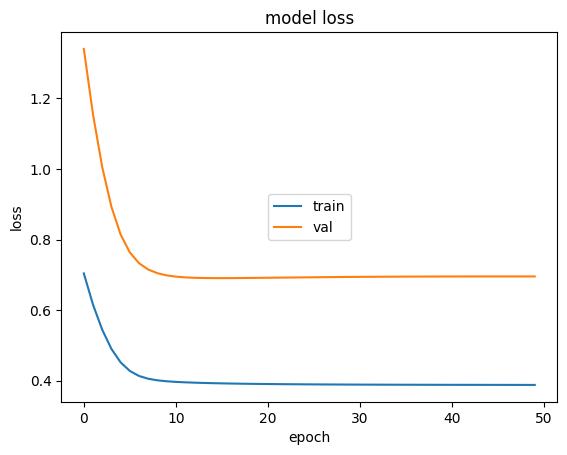

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

### evaluar el modelo

In [34]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3116 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6289
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1292


1.0361255407333374

In [38]:
prediccion_val = []
prediccion_val = prediccion_fun(x_val,modelo1,
                                1,
                                scaler,
                                dif=True,dif_cant=1,
                                Series = importaciones_regular_ts.values ,
                                n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1,
                                 1,
                                 scaler,
                                 dif=True,dif_cant=1,
                                 Series = importaciones_regular_ts.values,
                                 n = len(importaciones_regular_ts.values) - len(x_test))






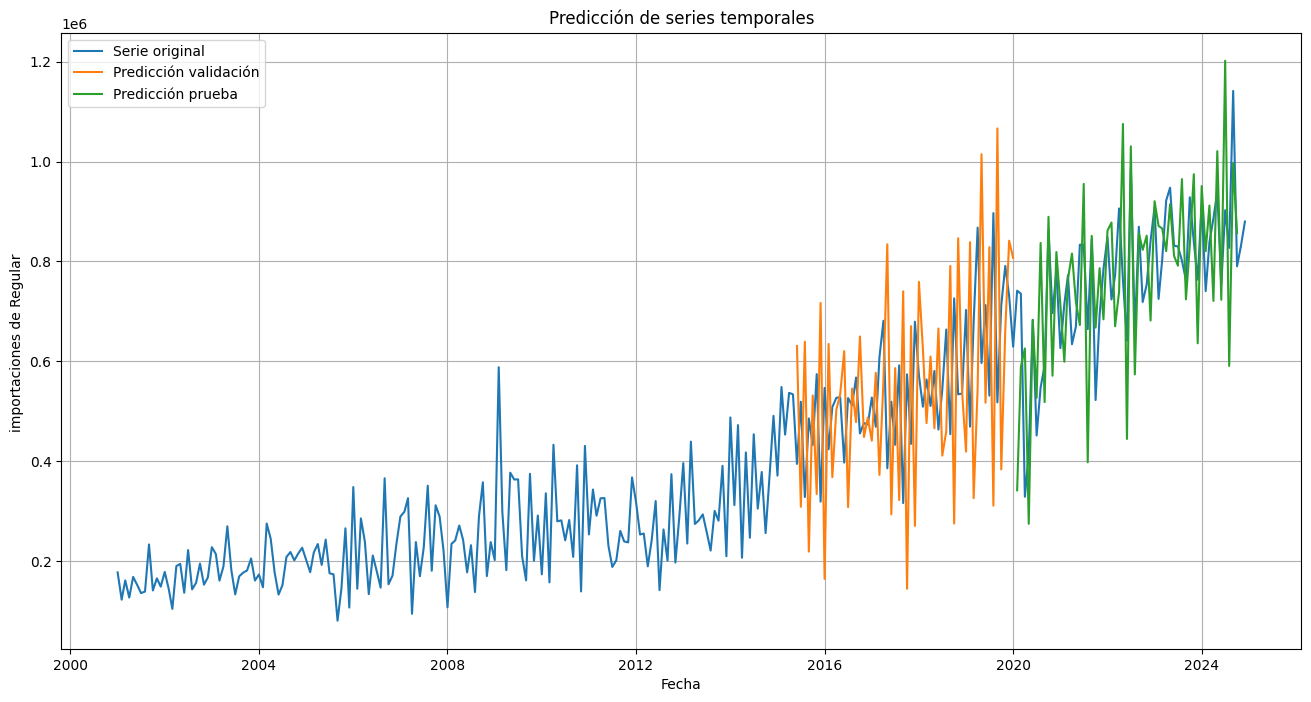

In [42]:
# Set larger figure size (width, height) in inches
plt.figure(figsize=(16, 8))

df_val = pd.DataFrame(prediccion_val, index=importaciones_regular_ts[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=importaciones_regular_ts[val_end:].index[:len(prediccion_test)])

plt.plot(importaciones_regular_ts, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('importaciones de Regular ')
plt.grid(True)
plt.show()


Para comenzar se ha decidido examinar la serie temporal de las importaciones de gasolina regular. Al observar la gráfica lo primero que se puede observar es una tendecia al alza a lo largo del tiempo. 

La serie presenta una gran cantidad de datos con varios picos, lo que hace difícil identificar patrones de estacionalidad. Por lo que será necesario un análisis más a profundidad para ideniticar esto.

Además, dada la gráfica se puede suponer de cierta manera la falta de estacionariedad. Viendo la gráfica se puede intuir que las propiedades estadísticas parecen cambiar con el tiempo, especialmente considerando esa tendencia creciente que se mencionó anteriormente. Claramente es solo una intuición y se profundizará más adelante. 

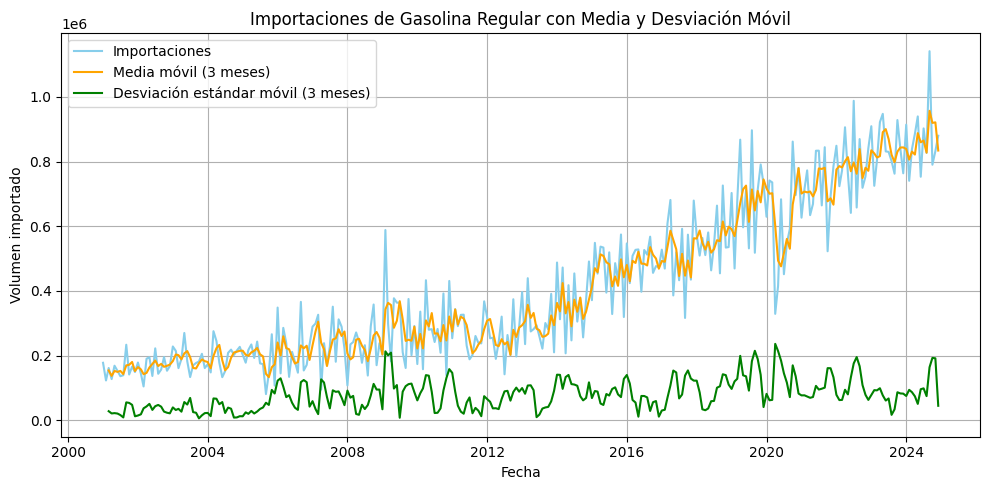

In [264]:
media_movil = importaciones_regular_ts.rolling(window=3).mean()
desviacion_movil = importaciones_regular_ts.rolling(window=3).std()

plt.figure(figsize=(10, 5))
plt.plot(importaciones_regular_ts, label='Importaciones', color='skyblue')
plt.plot(media_movil, label='Media móvil (3 meses)', color='orange')
plt.plot(desviacion_movil, label='Desviación estándar móvil (3 meses)', color='green')

plt.title('Importaciones de Gasolina Regular con Media y Desviación Móvil')
plt.xlabel('Fecha')
plt.ylabel('Volumen importado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


En esta gráfica se tiene tanto la media como al desviación estándar móvil de la serie. Es evidente que estas no se mantienen constante a lo largo del tiempo, reforzando la idea de que la serie no es estacionaria. 

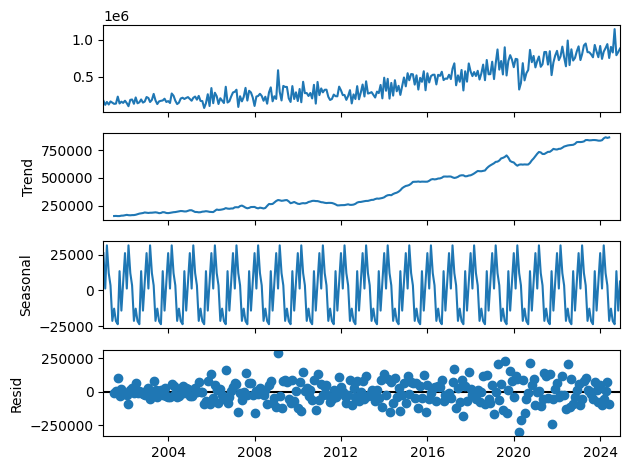

In [265]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie de tiempo
descomposicion = seasonal_decompose(importaciones_regular_ts, model='additive')

# Graficar la descomposición (tendencia, estacionalidad, residuo)
descomposicion.plot()
plt.tight_layout()
plt.show()

En esta gráfica se muestra la descomposición de la serie. Aquí ya se puede ver de una manera más clara no solo la tendencia a la alza, pero también la estacionalidad que no era clara al inicio. Además, se puede ver que los residuos se dispersan bastante en el tiempo. 

Considerando esto se concluye que
La serie tiene estacionalidad
No es estacionaria en la media, además cuenta con tendencia 
No es estacionaria en la varianza

Por lo tanto, es necesario aplicar transformaciones para hacerla estacionaria y luego aplicar un modelo como SARIMA.

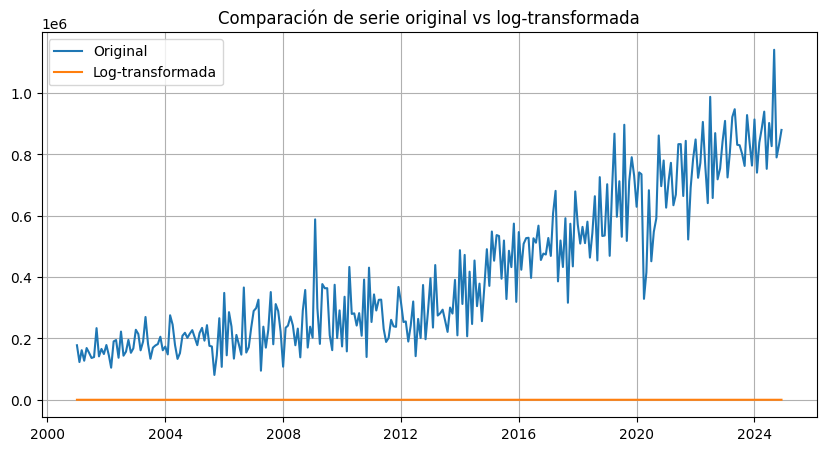

In [266]:
importaciones_regular_ts_log = np.log(importaciones_regular_ts)
plt.figure(figsize=(10, 5))
plt.plot(importaciones_regular_ts, label='Original')
plt.plot(importaciones_regular_ts_log, label='Log-transformada')
plt.title("Comparación de serie original vs log-transformada")
plt.legend()
plt.grid(True)
plt.show()


A través de este análisis gráfico se puede decir que se logro hacer estacionaria la desviación estándar móvil. Por lo que ahora es necesario hacer estacionario a la media movil. Para ello haremos una diferencia e identificar si se logra estacionar. 

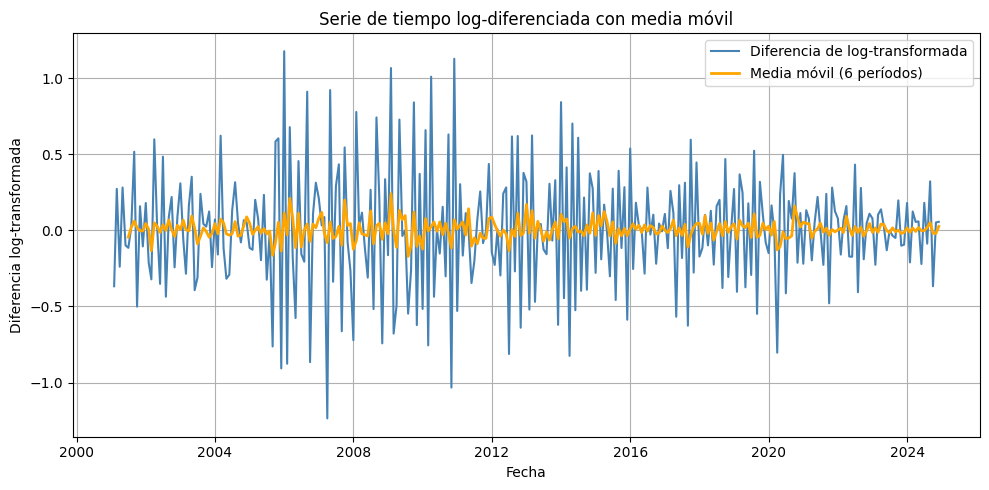

In [267]:
importaciones_regular_ts_log_diff = importaciones_regular_ts_log.diff().dropna()

media_movil = importaciones_regular_ts_log_diff.rolling(window=6).mean()

plt.figure(figsize=(10, 5))
plt.plot(importaciones_regular_ts_log_diff, label='Diferencia de log-transformada', color='steelblue')
plt.plot(media_movil, label='Media móvil (6 períodos)', color='orange', linewidth=2)

plt.title("Serie de tiempo log-diferenciada con media móvil")
plt.xlabel("Fecha")
plt.ylabel("Diferencia log-transformada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [268]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

print('Resultados del Test de Dickey-Fuller para la serie log-diferenciada')
dfTest = adfuller(importaciones_regular_ts_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf[f'Valor crítico ({key})'] = value
salidaDf

Resultados del Test de Dickey-Fuller para la serie log-diferenciada


Estadístico de prueba       -7.860881e+00
p-value                      5.288333e-12
# de retardos usados         1.200000e+01
# de observaciones usadas    2.740000e+02
Valor crítico (1%)          -3.454444e+00
Valor crítico (5%)          -2.872147e+00
Valor crítico (10%)         -2.572422e+00
dtype: float64

Luego de realizar la transformación logarítmica y la diferenciación ya se obtiene que la serie es estacionaria tanto en la media como en la desviación estándar. 

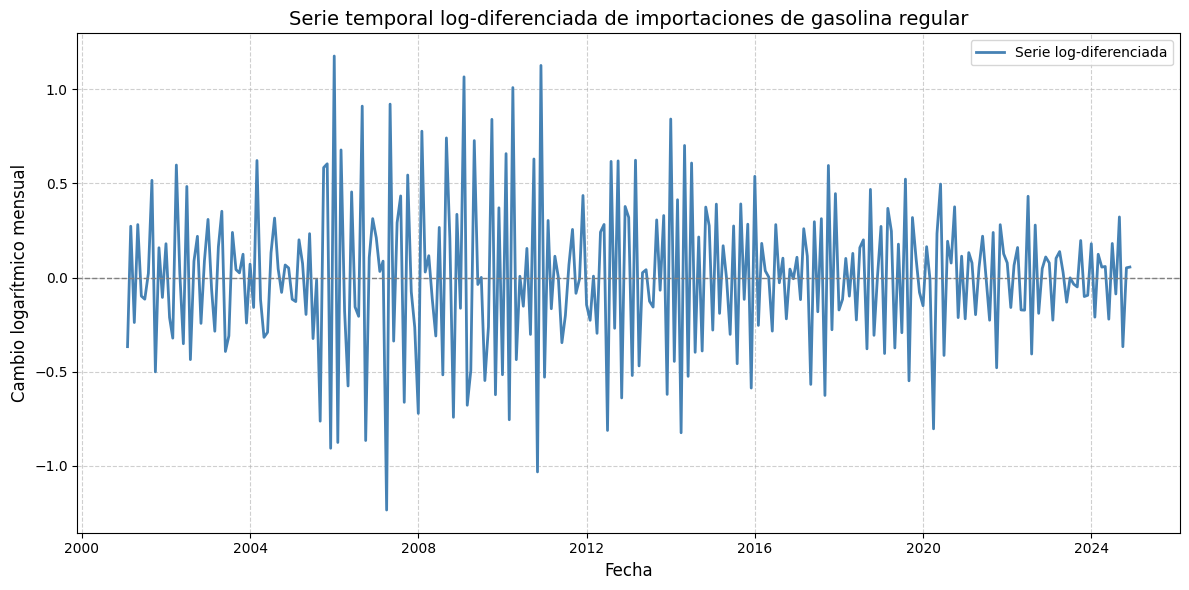

In [269]:
plt.figure(figsize=(12, 6))
plt.plot(importaciones_regular_ts_log_diff, label='Serie log-diferenciada', color='steelblue', linewidth=2)

# Mejoras visuales
plt.title('Serie temporal log-diferenciada de importaciones de gasolina regular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cambio logarítmico mensual', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # línea base
plt.legend()
plt.tight_layout()
plt.show()

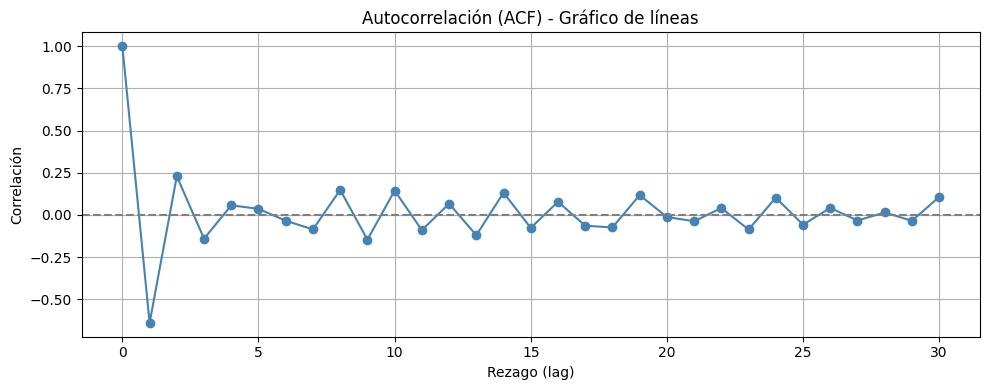

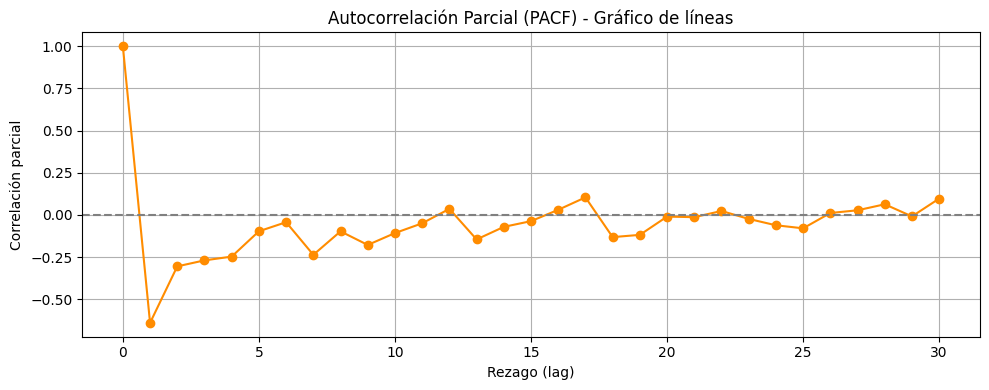

In [270]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import matplotlib.pyplot as plt

# Asegúrate de no tener nulos
serie = importaciones_regular_ts_log_diff.dropna()

# Calcular valores de ACF y PACF
acf_vals = acf(serie, nlags=30)
pacf_vals = pacf(serie, nlags=30, method='ywm')

# Eje de lags
lags = np.arange(len(acf_vals))

# Graficar ACF
plt.figure(figsize=(10, 4))
plt.plot(lags, acf_vals, marker='o', linestyle='-', color='steelblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación (ACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar PACF
plt.figure(figsize=(10, 4))
plt.plot(lags, pacf_vals, marker='o', linestyle='-', color='darkorange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación Parcial (PACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación parcial')
plt.grid(True)
plt.tight_layout()
plt.show()


De las gráficas de autocorrelación y autocorrelación parcial se puede intuir que se puede tratar de un modelo teórico ARIMA con parámetros p y q variando entre 1 y 2. Por lo que se propondrán 4 modelos y se comparará entre ellos para identificar cual es el más apropiado.

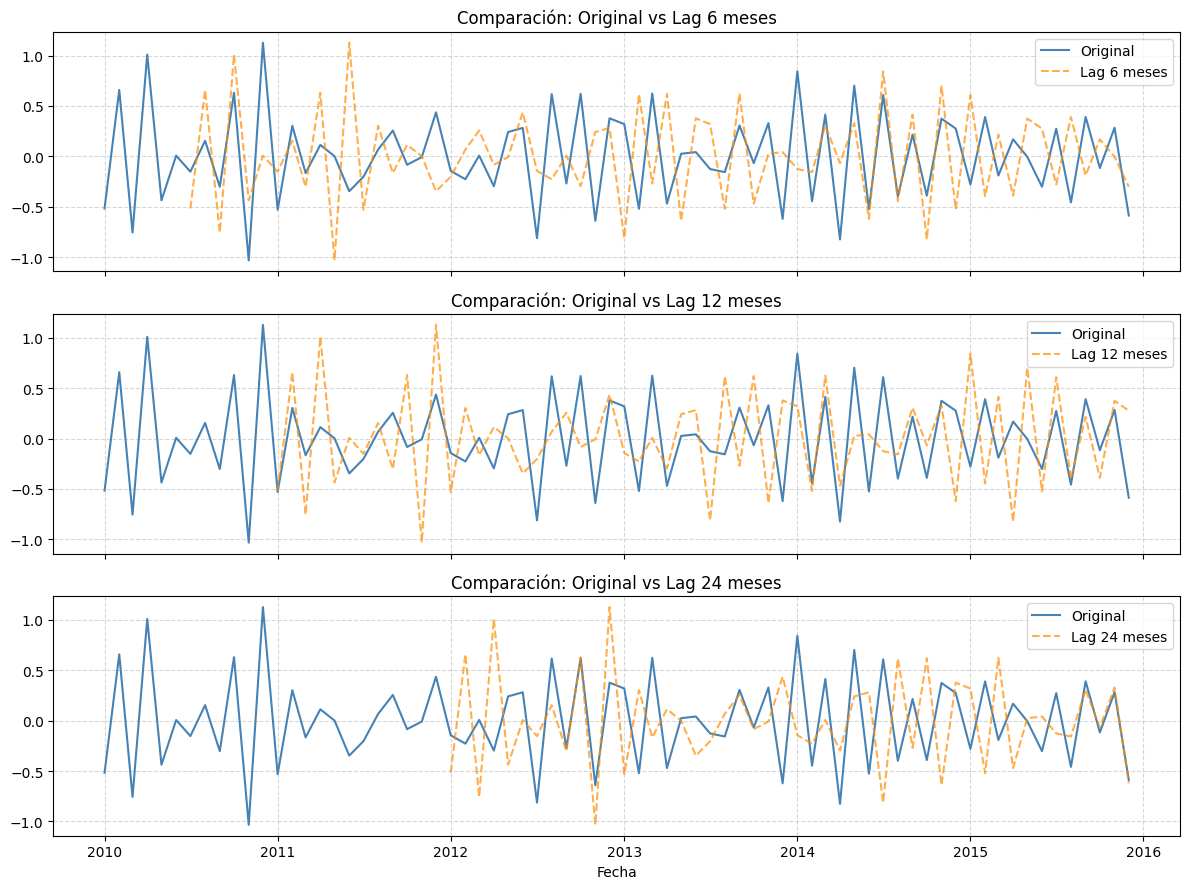

In [271]:
# Lags a mostrar
lags = [6, 12, 24]

# Recorte visual para que no se sature
serie_base = importaciones_regular_ts_log_diff['2010':'2015']

fig, axes = plt.subplots(len(lags), 1, figsize=(12, 9), sharex=True)

for i, lag in enumerate(lags):
    axes[i].plot(serie_base, label='Original', color='steelblue')
    axes[i].plot(serie_base.shift(lag), label=f'Lag {lag} meses', color='darkorange', linestyle='--', alpha=0.7)
    axes[i].set_title(f'Comparación: Original vs Lag {lag} meses')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


En las gráficas se puede notar cierta estacionalidad para un rezago de 12 meses. Por lo que se generarán modelos considerando la estacionalidad. Sin embargo, sería interesante, dado que tampoco es muy claro intentar, generar un modelo sin estacionalidad.

In [272]:
serie = importaciones_regular_ts_log.dropna()

# Modelos estacionales SARIMA(p,1,q)(P,1,Q,12)
modelos = {}

# SARIMA(1,1,1)(1,1,1,12)
modelos['SARIMA_111_111'] = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)

# SARIMA(2,1,1)(2,1,1,12)
modelos['SARIMA_211_211'] = SARIMAX(serie, order=(2,1,1), seasonal_order=(2,1,1,12)).fit(disp=False)

# SARIMA(1,1,2)(1,1,2,12)
modelos['SARIMA_112_112'] = SARIMAX(serie, order=(1,1,2), seasonal_order=(1,1,2,12)).fit(disp=False)

# SARIMA(2,1,2)(2,1,2,12)
modelos['SARIMA_212_212'] = SARIMAX(serie, order=(2,1,2), seasonal_order=(2,1,2,12)).fit(disp=False)

# Modelo ARIMA (sin componente estacional)
modelos['ARIMA_212'] = SARIMAX(serie, order=(2,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)


/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarnin

In [273]:
# Crear tabla de comparación
resultados = []

for nombre, modelo in modelos.items():
    resultados.append({
        'Modelo': nombre,
        'AIC': modelo.aic,
        'BIC': modelo.bic,
        'LogLik': modelo.llf
    })

# Mostrar en un DataFrame ordenado por AIC
import pandas as pd

comparacion = pd.DataFrame(resultados).sort_values(by='AIC').reset_index(drop=True)
print(comparacion)


           Modelo        AIC         BIC     LogLik
0       ARIMA_212  51.842647   70.140058 -20.921323
1  SARIMA_112_112  74.541052   99.858450 -30.270526
2  SARIMA_111_111  74.679012   92.762868 -32.339506
3  SARIMA_212_212  75.736137  108.287077 -28.868069
4  SARIMA_211_211  75.908415  101.225812 -30.954207


Como se intuía, resulta ser el modelo sin estacionalidad el que tiene un mejor desempeño. Por lo que ahora se generarán modelos sin la componente estacional para determinar cuál es mejor. 

In [274]:
# Asegúrate de tener la serie sin nulos y con frecuencia mensual
serie = importaciones_regular_ts_log.dropna()

# Diccionario para guardar modelos
modelos_arima = {}

# Probar combinaciones de p y q entre 1 y 2
for p in [1, 2]:
    for q in [1, 2]:
        nombre = f'ARIMA_{p}1{q}'
        try:
            modelo = SARIMAX(serie, order=(p, 1, q), seasonal_order=(0, 0, 0, 0))
            resultados = modelo.fit(disp=False)
            modelos_arima[nombre] = resultados
        except Exception as e:
            print(f"Error al ajustar {nombre}: {e}")


/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

In [275]:
resultados_arima = []

for nombre, modelo in modelos_arima.items():
    resultados_arima.append({
        'Modelo': nombre,
        'AIC': modelo.aic,
        'BIC': modelo.bic,
        'LogLik': modelo.llf
    })


comparacion_arima = pd.DataFrame(resultados_arima).sort_values(by='AIC').reset_index(drop=True)
print(comparacion_arima)


      Modelo        AIC        BIC     LogLik
0  ARIMA_111  49.279570  60.258016 -21.639785
1  ARIMA_112  49.874288  64.512217 -20.937144
2  ARIMA_211  50.367804  65.005733 -21.183902
3  ARIMA_212  51.842647  70.140058 -20.921323


A partir de esta comparación de modelos pueden ser utilizados el modelo ARIMA_112 o el modelo ARIMA212, la diferencia entre ellos es mínima por lo que a la hora de generar modelos es altamente probable que no haya mucha diferencia. Sin embargo al final un modelo más simple puede generalizar mejor, por ello se recomienda utilizar un modelo ARIMA_112 para una predicción futura.

## Gasolina Regular 
### Consumo



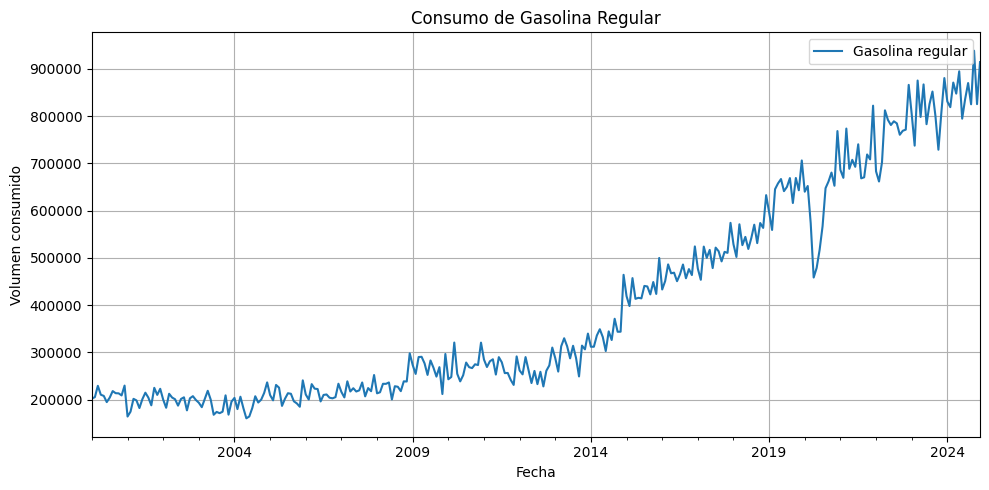

In [276]:
consumos_regular_ts.plot(figsize=(10, 5), title='Consumo de Gasolina Regular')
plt.xlabel("Fecha")
plt.ylabel("Volumen consumido")
plt.grid(True)
plt.tight_layout()
plt.show()

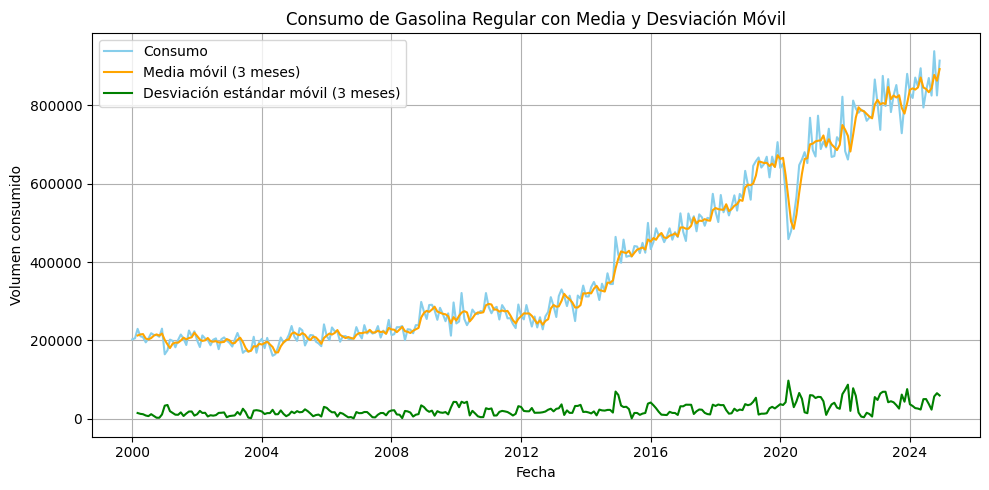

In [277]:
media_movil = consumos_regular_ts.rolling(window=3).mean()
desviacion_movil = consumos_regular_ts.rolling(window=3).std()

plt.figure(figsize=(10, 5))
plt.plot(consumos_regular_ts, label='Consumo', color='skyblue')
plt.plot(media_movil, label='Media móvil (3 meses)', color='orange')
plt.plot(desviacion_movil, label='Desviación estándar móvil (3 meses)', color='green')

plt.title('Consumo de Gasolina Regular con Media y Desviación Móvil')
plt.xlabel('Fecha')
plt.ylabel('Volumen consumido')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

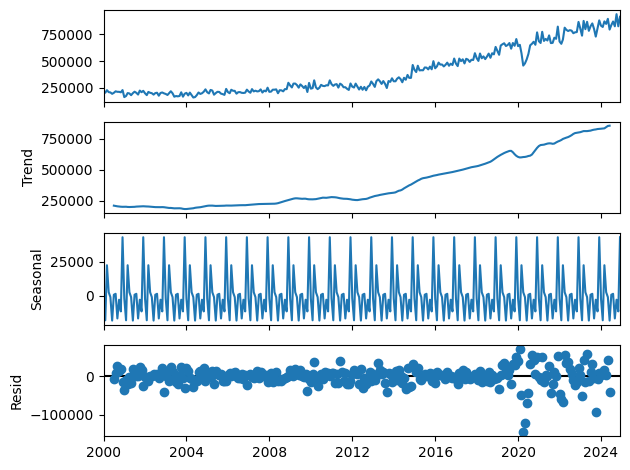

In [278]:
# Descomponer la serie de tiempo
descomposicion = seasonal_decompose(consumos_regular_ts, model='additive')

# Graficar la descomposición (tendencia, estacionalidad, residuo)
descomposicion.plot()
plt.tight_layout()
plt.show()

A partir de esas graficas podemos notar:
- La media tiene cierta tendencia a la alza
- La grafica de estacionalidad tiene patrones repetitivos lo que parece indicar que esta serie de tiempo tiene estacionalidad
- Del año 2000 al 2019 parece que la varienza no tiene ningun patron claro, pero apartir de 2020 si bien pasado ese año no se nota un patron claro, se a aumentado la dispercion de los residuos. Puedria ser buena idea eliminar el año 2020 para el entrenamiento del modelo

## Estimar los parámetros del modelo
La grafica anterior nos sugiere que la serie de tiempo para consumo de regular es estacionaria en varianza 


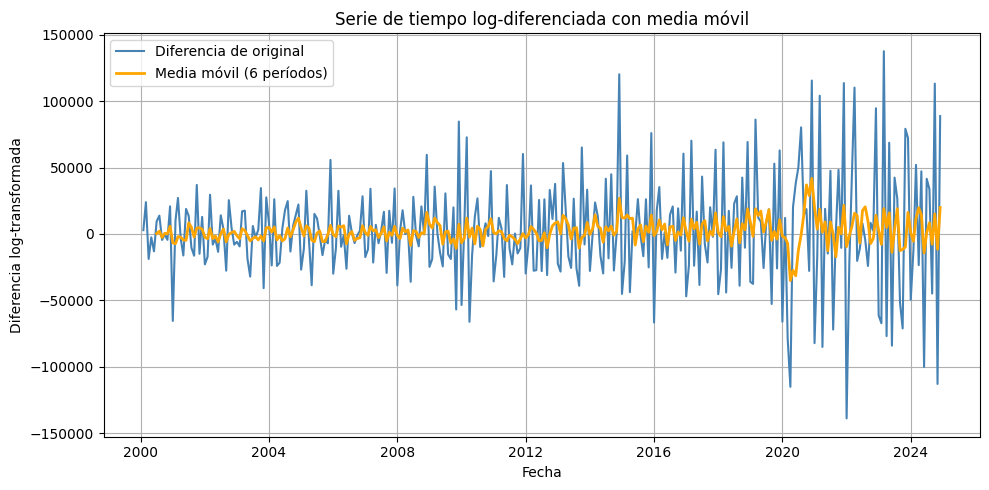

In [279]:
consumos_regular_ts_diff = consumos_regular_ts.diff().dropna()

media_movil = consumos_regular_ts_diff.rolling(window=6).mean()

plt.figure(figsize=(10, 5))
plt.plot(consumos_regular_ts_diff, label='Diferencia de original', color='steelblue')
plt.plot(media_movil, label='Media móvil (6 períodos)', color='orange', linewidth=2)

plt.title("Serie de tiempo log-diferenciada con media móvil")
plt.xlabel("Fecha")
plt.ylabel("Diferencia log-transformada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [280]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumos_regular_ts_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -4.341663
p-value                        0.000376
# de retardos usados          16.000000
# de observaciones usadas    282.000000
Critical Value (1%)           -3.453754
Critical Value (5%)           -2.871844
Critical Value (10%)          -2.572261
dtype: float64


El p-valor de la prueba de Dickey Fuller es menor a 0.001, por lo que se puede concluir que la serie de tiempo de regular transformada aoura tiene media estacionaria. 

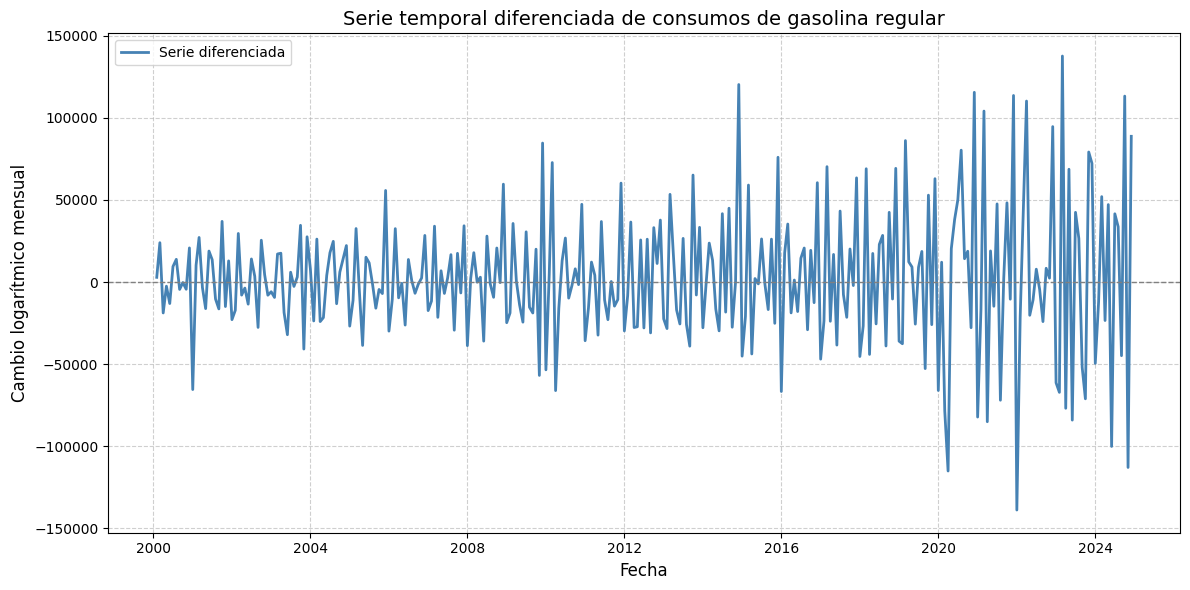

In [281]:
plt.figure(figsize=(12, 6))
plt.plot(consumos_regular_ts_diff, label='Serie diferenciada', color='steelblue', linewidth=2)

# Mejoras visuales
plt.title('Serie temporal diferenciada de consumos de gasolina regular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cambio logarítmico mensual', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # línea base
plt.legend()
plt.tight_layout()
plt.show()

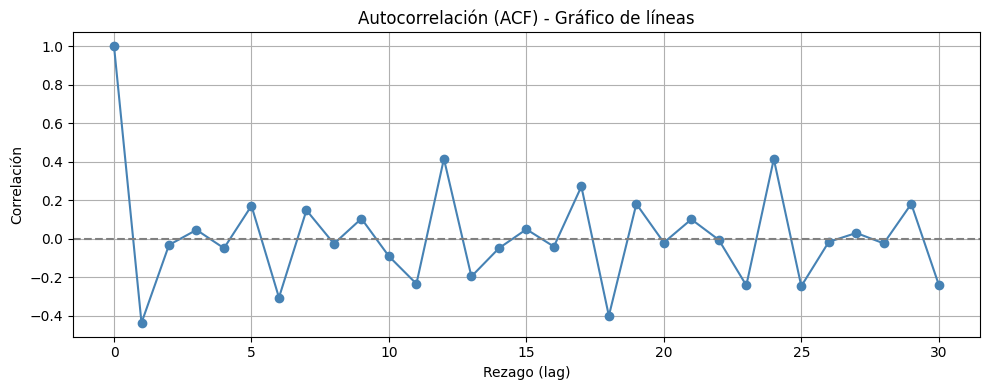

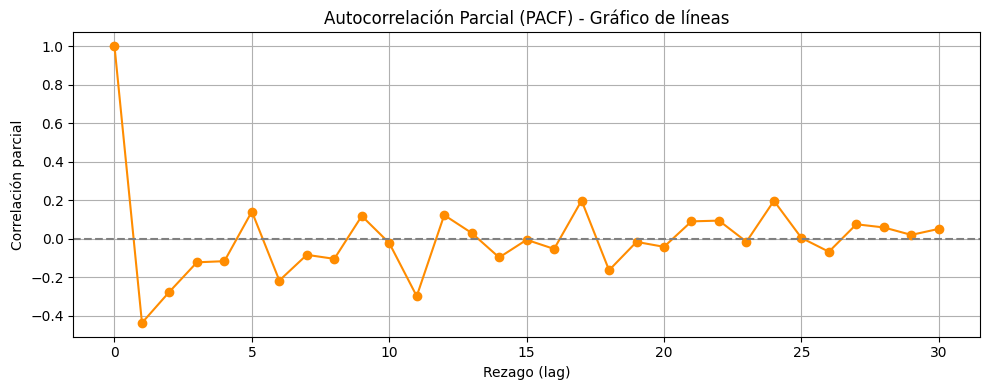

In [282]:
# Asegúrate de no tener nulos
serie = consumos_regular_ts_diff.dropna()

# Calcular valores de ACF y PACF
acf_vals = acf(serie, nlags=30)
pacf_vals = pacf(serie, nlags=30, method='ywm')

# Eje de lags
lags = np.arange(len(acf_vals))

# Graficar ACF
plt.figure(figsize=(10, 4))
plt.plot(lags, acf_vals, marker='o', linestyle='-', color='steelblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación (ACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar PACF
plt.figure(figsize=(10, 4))
plt.plot(lags, pacf_vals, marker='o', linestyle='-', color='darkorange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación Parcial (PACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación parcial')
plt.grid(True)
plt.tight_layout()
plt.show()


Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un MA(q). Podíamos probar varios modelos ARIMA:

    p=0, q=1
    p=1, q=2

En ambos casos solo es necesaria una diferenciación por lo que d=2


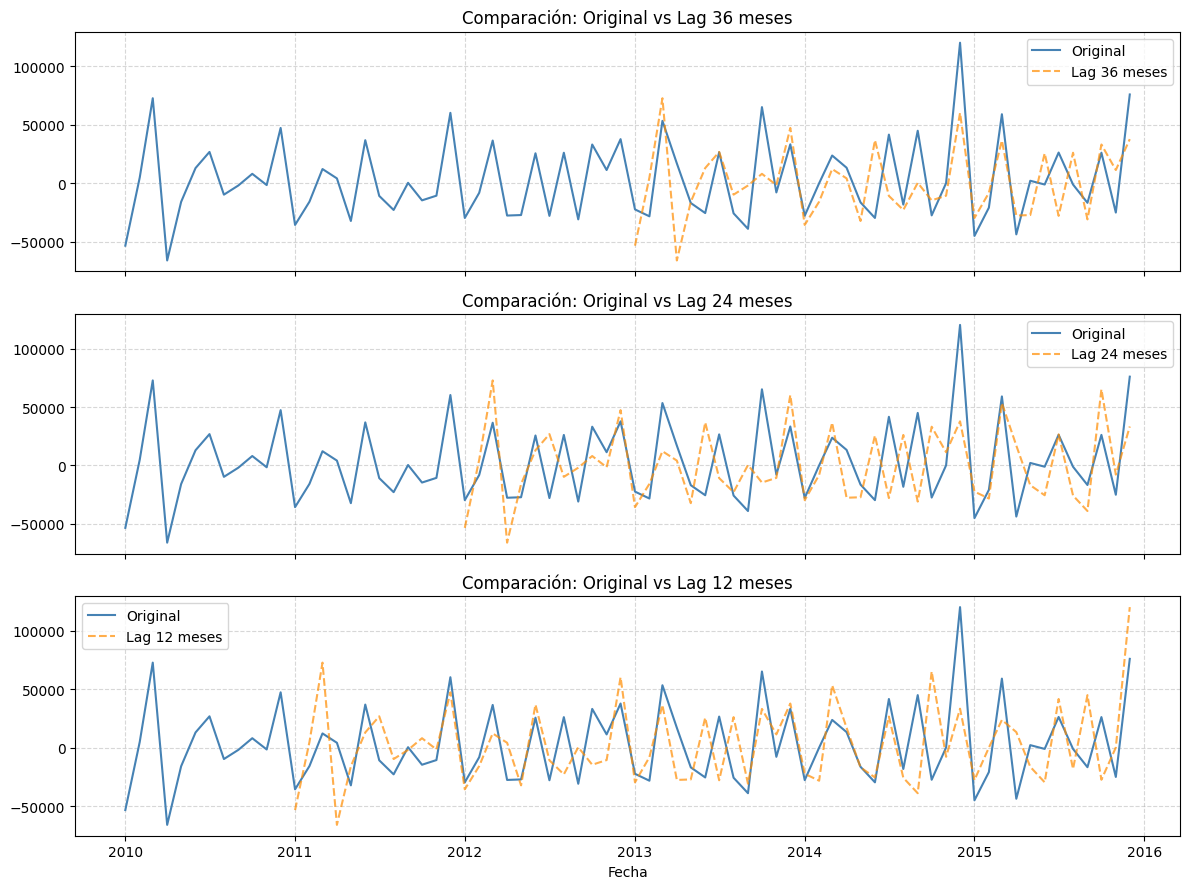

In [283]:
# Lags a mostrar
lags = [36, 24, 12]

# Recorte visual para que no se sature
serie_base = consumos_regular_ts_diff['2010':'2015']

fig, axes = plt.subplots(len(lags), 1, figsize=(12, 9), sharex=True)

for i, lag in enumerate(lags):
    axes[i].plot(serie_base, label='Original', color='steelblue')
    axes[i].plot(serie_base.shift(lag), label=f'Lag {lag} meses', color='darkorange', linestyle='--', alpha=0.7)
    axes[i].set_title(f'Comparación: Original vs Lag {lag} meses')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()



In [284]:
serie = consumos_regular_ts.dropna()

# Modelos estacionales SARIMA(p,1,q)(P,1,Q,12)
modelos = {}

#
modelos['SARIMA_011'] = SARIMAX(serie, order=(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)

# SARIMA(2,1,1)(2,1,1,12)
modelos['SARIMA_111'] = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,2,12)).fit(disp=False)



/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: User

In [285]:
# Crear tabla de comparación
resultados = []

for nombre, modelo in modelos.items():
    resultados.append({
        'Modelo': nombre,
        'AIC': modelo.aic,
        'BIC': modelo.bic,
        'LogLik': modelo.llf
    })

# Mostrar en un DataFrame ordenado por AIC
import pandas as pd

comparacion = pd.DataFrame(resultados).sort_values(by='AIC').reset_index(drop=True)
print(comparacion)

       Modelo          AIC          BIC       LogLik
0  SARIMA_011  6773.720876  6784.699323 -3383.860438
1  SARIMA_111  6778.036605  6799.993498 -3383.018303


Entre estos 2 modelos el SARIMA_0011 parece ser un poco mejor, pues tienen menor AIC y BIC.

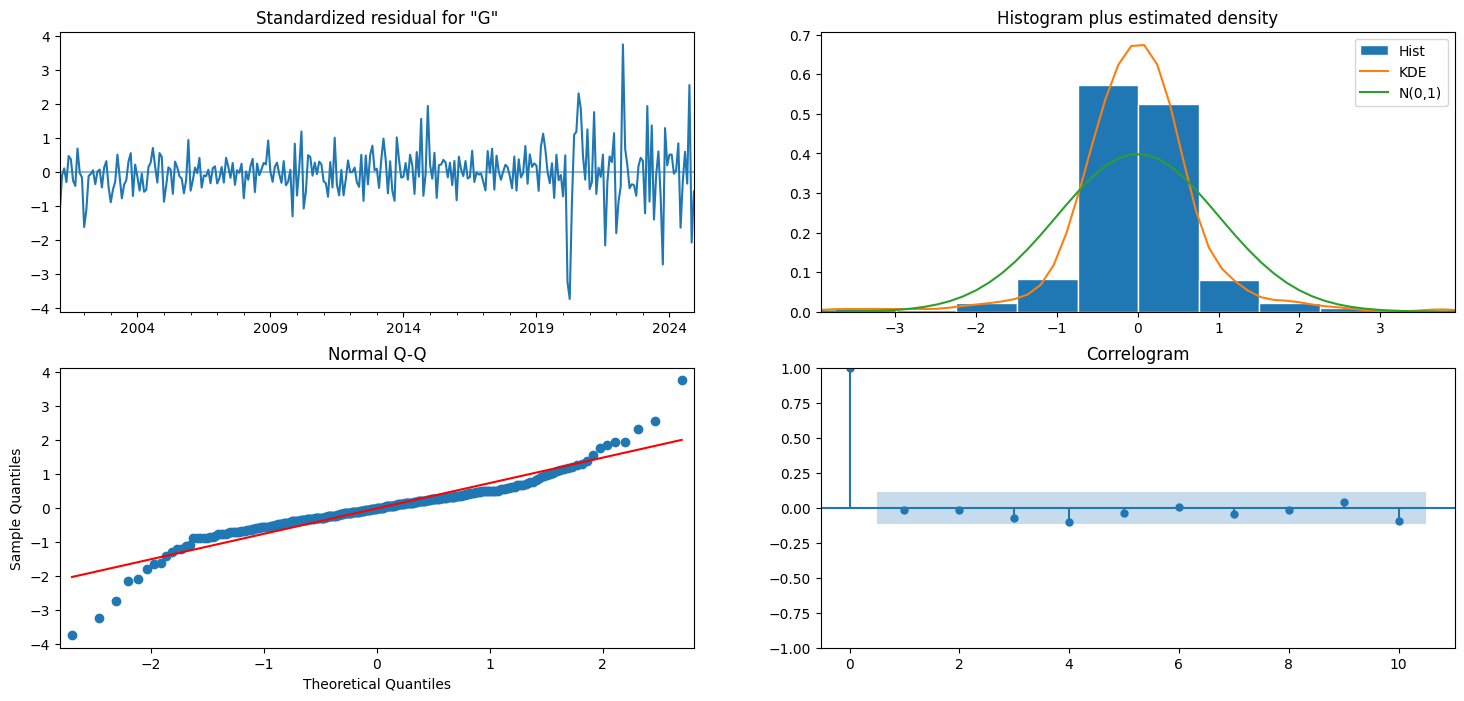

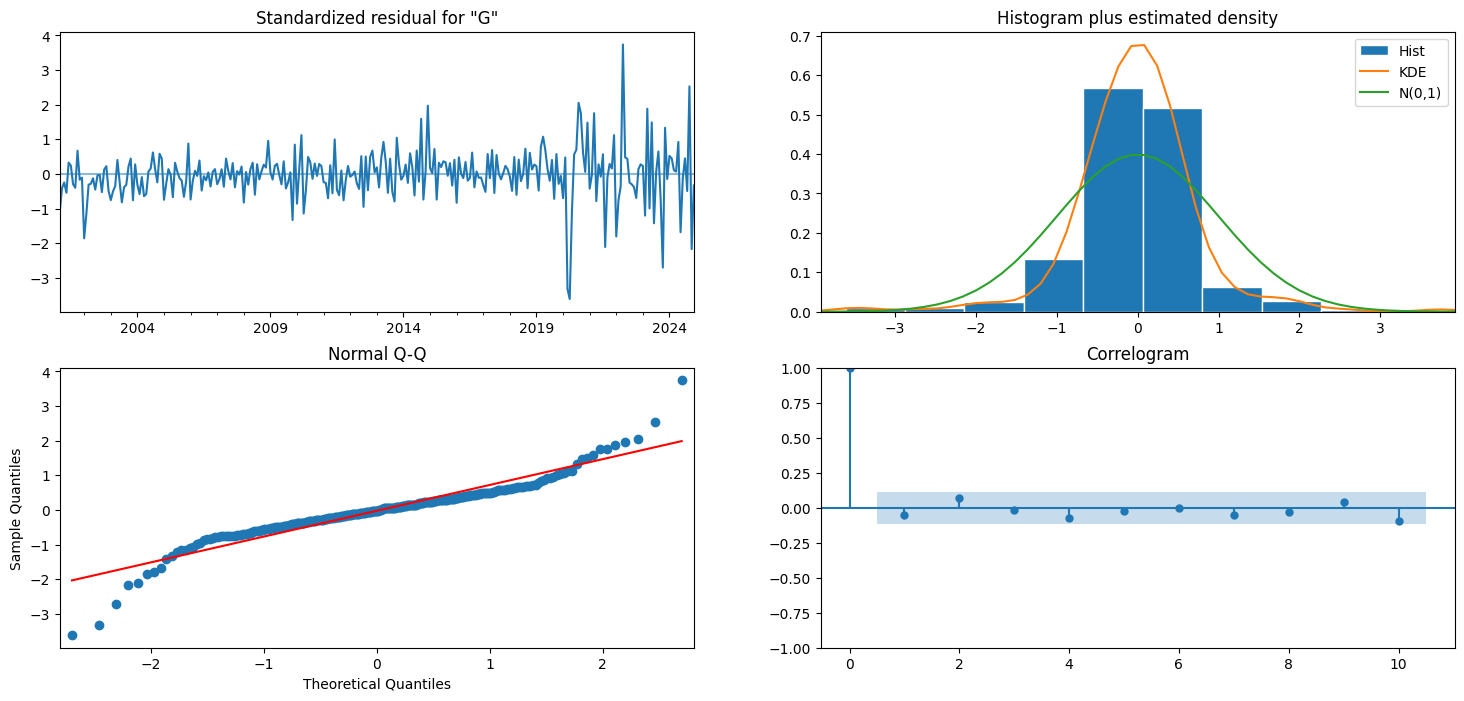

In [286]:
modelos['SARIMA_011'].plot_diagnostics(figsize=(18, 8))
plt.show()
modelos['SARIMA_111'].plot_diagnostics(figsize=(18, 8))
plt.show()

Graficamente casi todas las graficas se ven igual exceptuando la gráfica Q-Q. Para el modelo SARIMA_011 los puntos de la gráfica de la cola isquierda estan más pegados por lo que el modelo es un poco mejor. 
### Predicion enero-mayo 2025:

In [306]:
# Asegurar que el índice tenga frecuencia mensual
serie.index = pd.to_datetime(serie.index)
serie = serie.asfreq('MS')

# Fechas a predecir
pred_fechas = pd.date_range(start='2025-01-01', end='2025-05-01', freq='MS')

# Número de pasos de predicción
n_steps = len(pred_fechas)

# Predicción
pred_sarima = modelos['SARIMA_011'].get_forecast(steps=n_steps)
predicciones = pred_sarima.predicted_mean
predicciones.index = pred_fechas




In [318]:
consumoPred_regular_ts.dropna()
consumo_real = consumoPred_regular_ts['Gasolina regular']  # Ahora es una Series

comparacion = pd.DataFrame({
    'Predicción SARIMA': predicciones,
    'Valor real': consumo_real
})
comparacion.dropna()
comparacion['Error %'] = (comparacion['Predicción SARIMA']-comparacion["Valor real"])/comparacion["Valor real"]*100
comparacion.dropna()


Predicción SARIMA  Valor real    Error %
2025-01-01      858828.261305   788005.35   8.987618
2025-02-01      836696.689764   857375.76  -2.411903
2025-03-01      896464.363007   800182.17  12.032534
2025-04-01      870740.570836   898147.98  -3.051547
2025-05-01      891722.788078   785675.37  13.497613

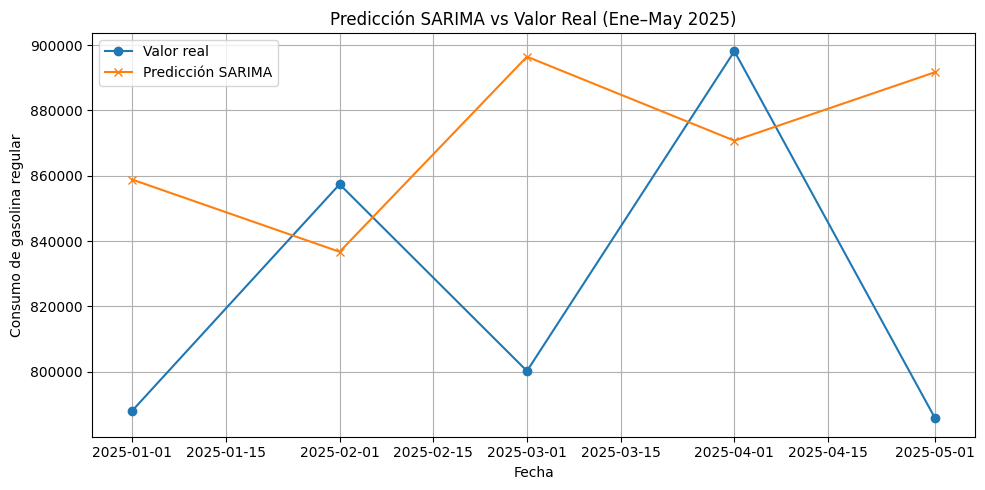

In [312]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(comparacion.index, comparacion['Valor real'], label='Valor real', marker='o')
plt.plot(comparacion.index, comparacion['Predicción SARIMA'], label='Predicción SARIMA', marker='x')
plt.title('Predicción SARIMA vs Valor Real (Ene–May 2025)')
plt.xlabel('Fecha')
plt.ylabel('Consumo de gasolina regular')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


La prediccion es aceptable pues los errores son cercanos al 10%.

## Gasolina Super
### Consumo

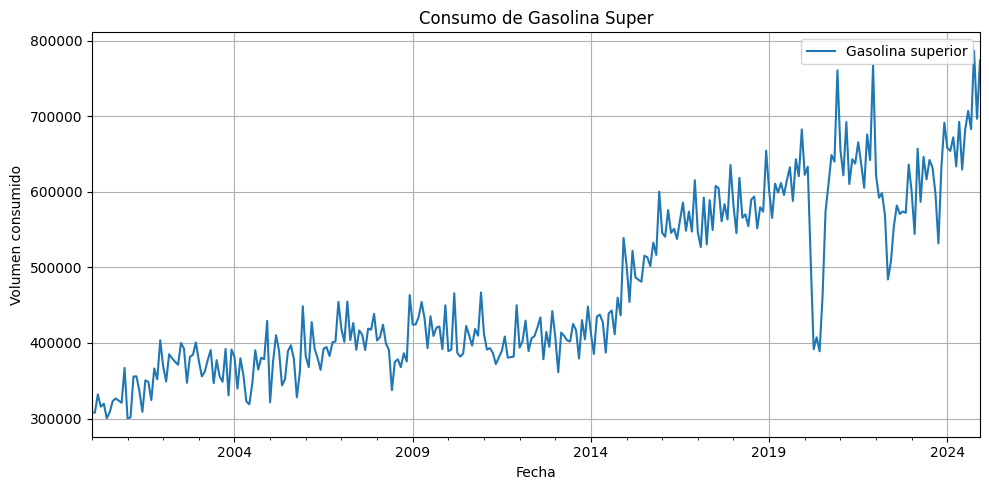

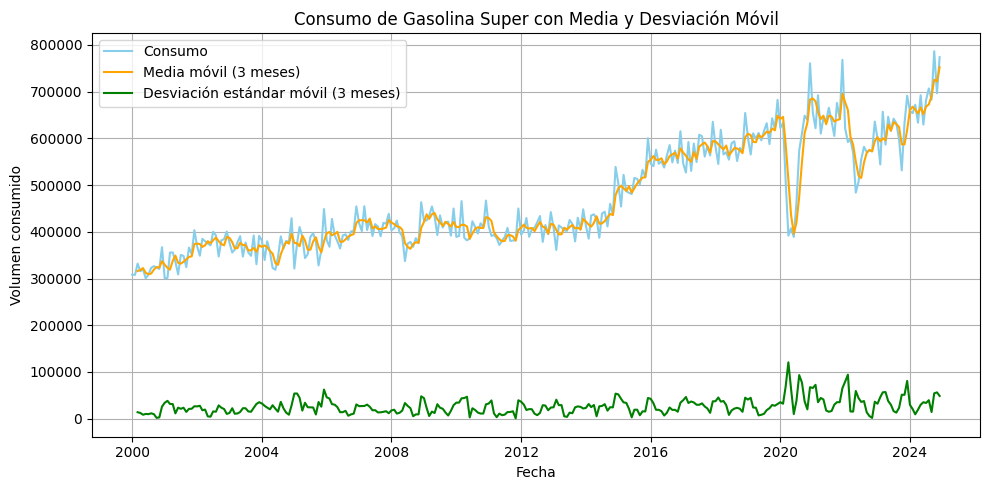

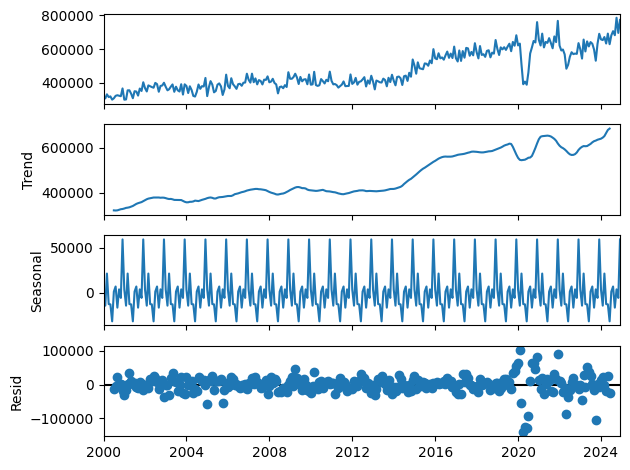

In [89]:
consumos_super_ts.plot(figsize=(10, 5), title='Consumo de Gasolina Super')
plt.xlabel("Fecha")
plt.ylabel("Volumen consumido")
plt.grid(True)
plt.tight_layout()
plt.show()
media_movil = consumos_super_ts.rolling(window=3).mean()
desviacion_movil = consumos_super_ts.rolling(window=3).std()

plt.figure(figsize=(10, 5))
plt.plot(consumos_super_ts, label='Consumo', color='skyblue')
plt.plot(media_movil, label='Media móvil (3 meses)', color='orange')
plt.plot(desviacion_movil, label='Desviación estándar móvil (3 meses)', color='green')

plt.title('Consumo de Gasolina Super con Media y Desviación Móvil')
plt.xlabel('Fecha')
plt.ylabel('Volumen consumido')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Descomponer la serie de tiempo
descomposicion = seasonal_decompose(consumos_super_ts, model='additive')

# Graficar la descomposición (tendencia, estacionalidad, residuo)
descomposicion.plot()
plt.tight_layout()
plt.show()


Similar al consumo de Regular, A partir de esas graficas podemos notar:

    La media tiene cierta tendencia a la alza
    La grafica de estacionalidad tiene patrones repetitivos lo que parece indicar que esta serie de tiempo tiene estacionalidad
    Del año 2000 al 2019 parece que la varienza no tiene ningun patron claro, pero apartir de 2020 si bien pasado ese año no se nota un patron claro, se a aumentado la dispercion de los residuos. 

# Estimar los parámetros del modelo

La grafica anterior nos sugiere que la serie de tiempo para consumo de super es estacionaria en varianza

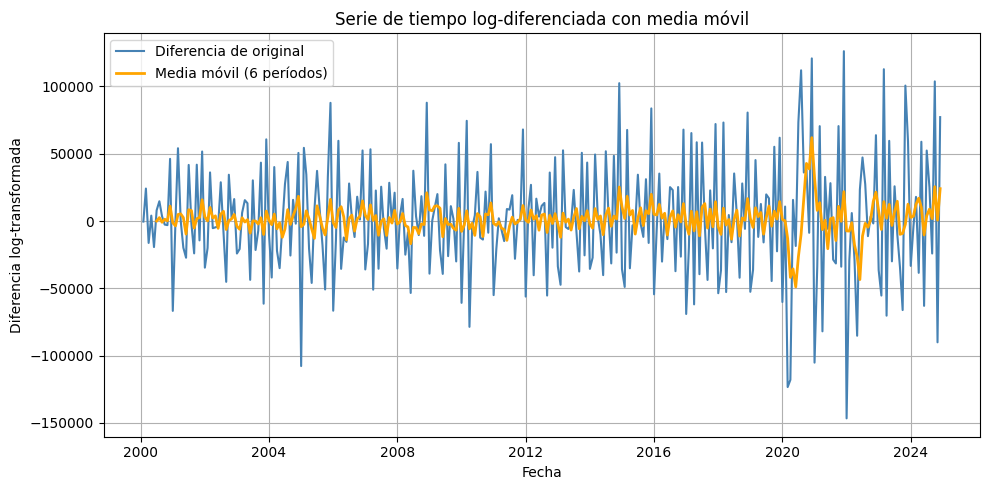

In [94]:
consumos_super_ts_diff = consumos_super_ts.diff().dropna()

media_movil = consumos_super_ts_diff.rolling(window=6).mean()

plt.figure(figsize=(10, 5))
plt.plot(consumos_super_ts_diff, label='Diferencia de original', color='steelblue')
plt.plot(media_movil, label='Media móvil (6 períodos)', color='orange', linewidth=2)

plt.title("Serie de tiempo log-diferenciada con media móvil")
plt.xlabel("Fecha")
plt.ylabel("Diferencia log-transformada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumos_super_ts_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -4.455130
p-value                        0.000237
# de retardos usados          16.000000
# de observaciones usadas    282.000000
Critical Value (1%)           -3.453754
Critical Value (5%)           -2.871844
Critical Value (10%)          -2.572261
dtype: float64


El p-valor de la prueba de Dickey Fuller es menor a 0.001, por lo que se puede concluir que la serie de tiempo de super transformada aoura tiene media estacionaria.

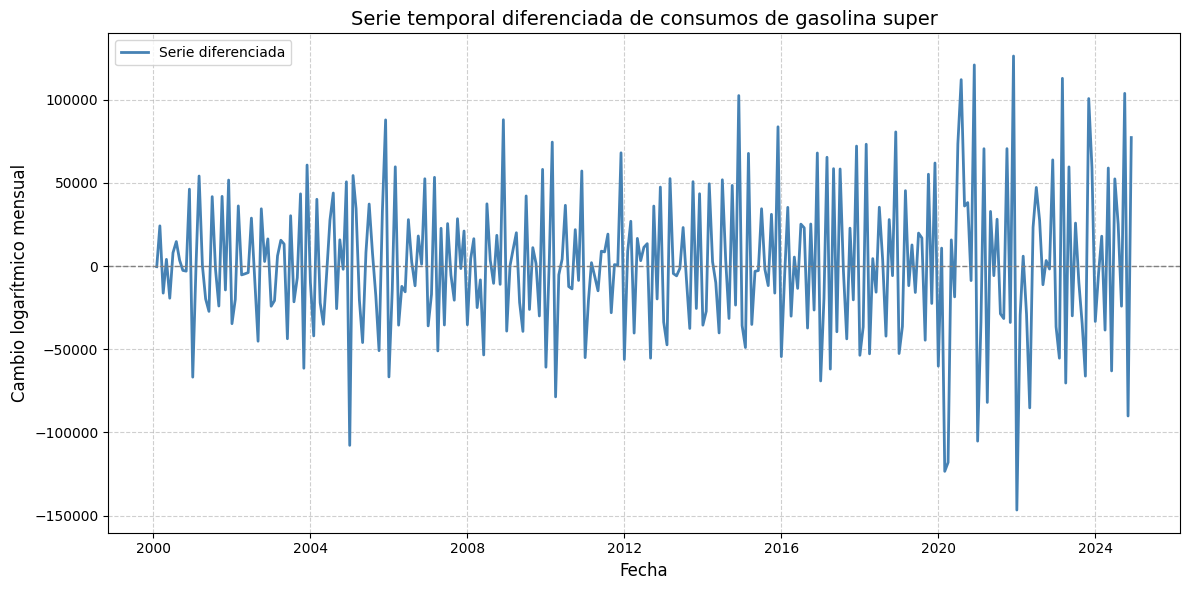

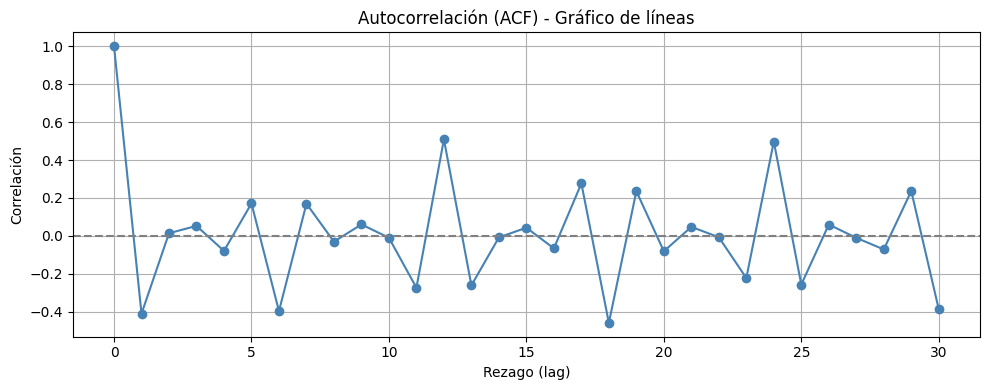

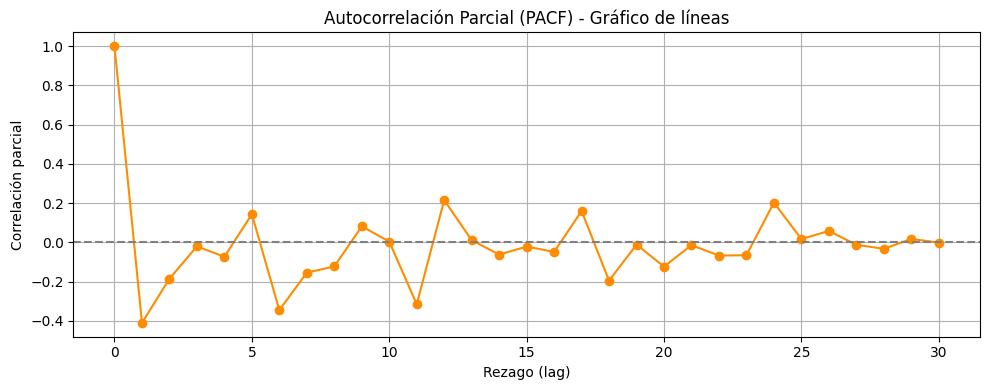

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(consumos_super_ts_diff, label='Serie diferenciada', color='steelblue', linewidth=2)

# Mejoras visuales
plt.title('Serie temporal diferenciada de consumos de gasolina super', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cambio logarítmico mensual', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # línea base
plt.legend()
plt.tight_layout()
plt.show()


# Asegúrate de no tener nulos
serie = consumos_super_ts_diff.dropna()

# Calcular valores de ACF y PACF
acf_vals = acf(serie, nlags=30)
pacf_vals = pacf(serie, nlags=30, method='ywm')

# Eje de lags
lags = np.arange(len(acf_vals))

# Graficar ACF
plt.figure(figsize=(10, 4))
plt.plot(lags, acf_vals, marker='o', linestyle='-', color='steelblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación (ACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar PACF
plt.figure(figsize=(10, 4))
plt.plot(lags, pacf_vals, marker='o', linestyle='-', color='darkorange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación Parcial (PACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación parcial')
plt.grid(True)
plt.tight_layout()
plt.show()

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un MA(q). Podíamos probar varios modelos ARIMA:

- p=0, q=1
- p=1, q=2

En ambos casos solo es necesaria una diferenciación por lo que d=2


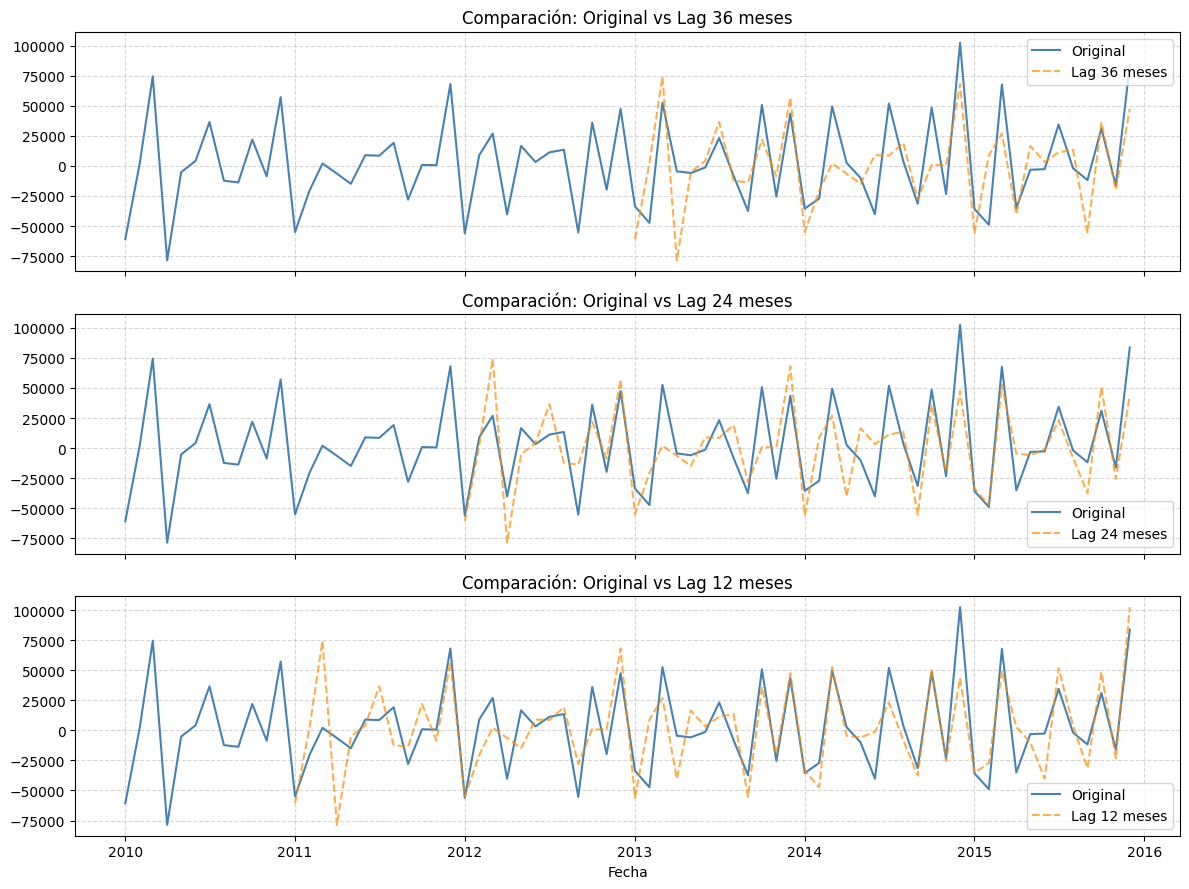

/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


       Modelo          AIC          BIC       LogLik
0  SARIMA_011  6804.860165  6815.838611 -3399.430082
1  SARIMA_111  6810.273141  6832.230034 -3399.136571


In [321]:
# Lags a mostrar
lags = [36, 24, 12]

# Recorte visual para que no se sature
serie_base = consumos_super_ts_diff['2010':'2015']

fig, axes = plt.subplots(len(lags), 1, figsize=(12, 9), sharex=True)

for i, lag in enumerate(lags):
    axes[i].plot(serie_base, label='Original', color='steelblue')
    axes[i].plot(serie_base.shift(lag), label=f'Lag {lag} meses', color='darkorange', linestyle='--', alpha=0.7)
    axes[i].set_title(f'Comparación: Original vs Lag {lag} meses')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

serie = consumos_super_ts.dropna()

# Modelos estacionales SARIMA(p,1,q)(P,1,Q,12)
modelos = {}

#
modelos['SARIMA_011'] = SARIMAX(serie, order=(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)

# SARIMA(2,1,1)(2,1,1,12)
modelos['SARIMA_111'] = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,2,12)).fit(disp=False)



# Crear tabla de comparación
resultados = []

for nombre, modelo in modelos.items():
    resultados.append({
        'Modelo': nombre,
        'AIC': modelo.aic,
        'BIC': modelo.bic,
        'LogLik': modelo.llf
    })

# Mostrar en un DataFrame ordenado por AIC
import pandas as pd

comparacion = pd.DataFrame(resultados).sort_values(by='AIC').reset_index(drop=True)
print(comparacion)

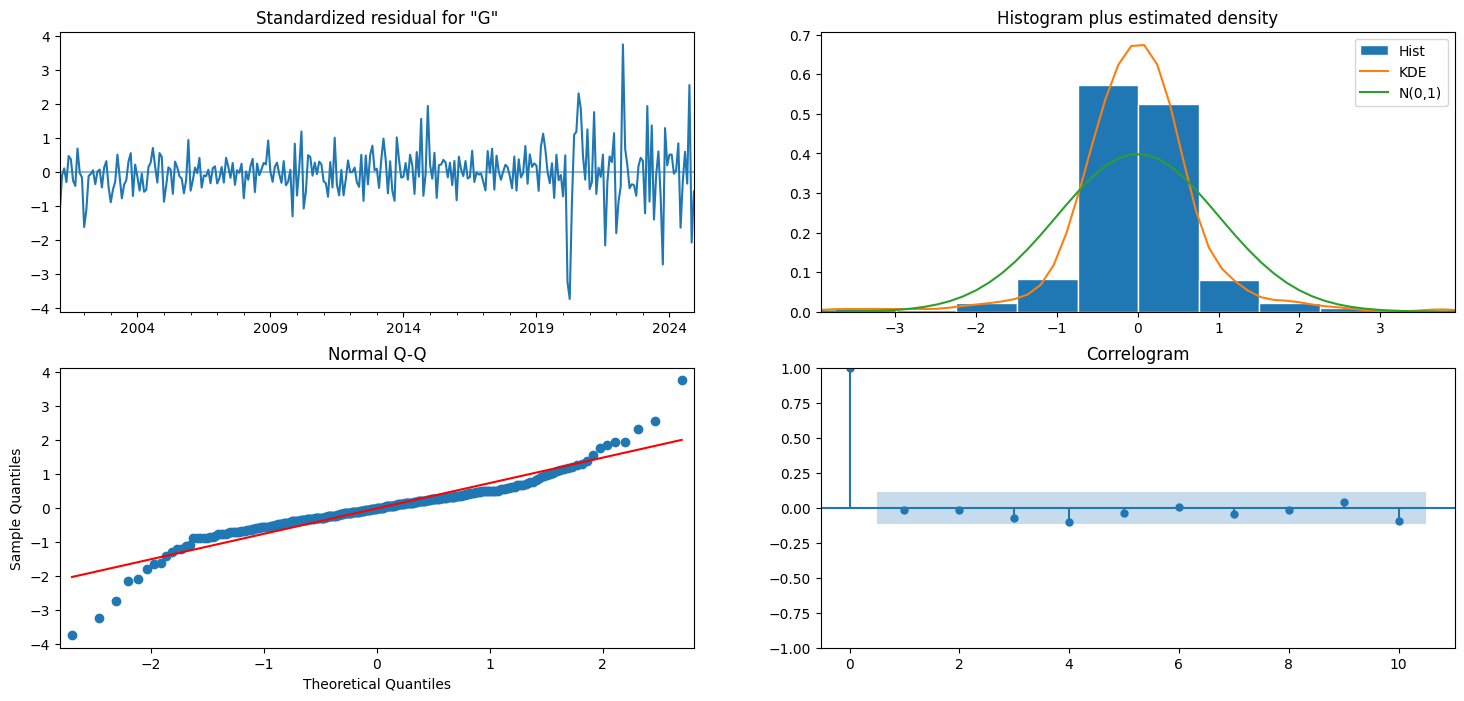

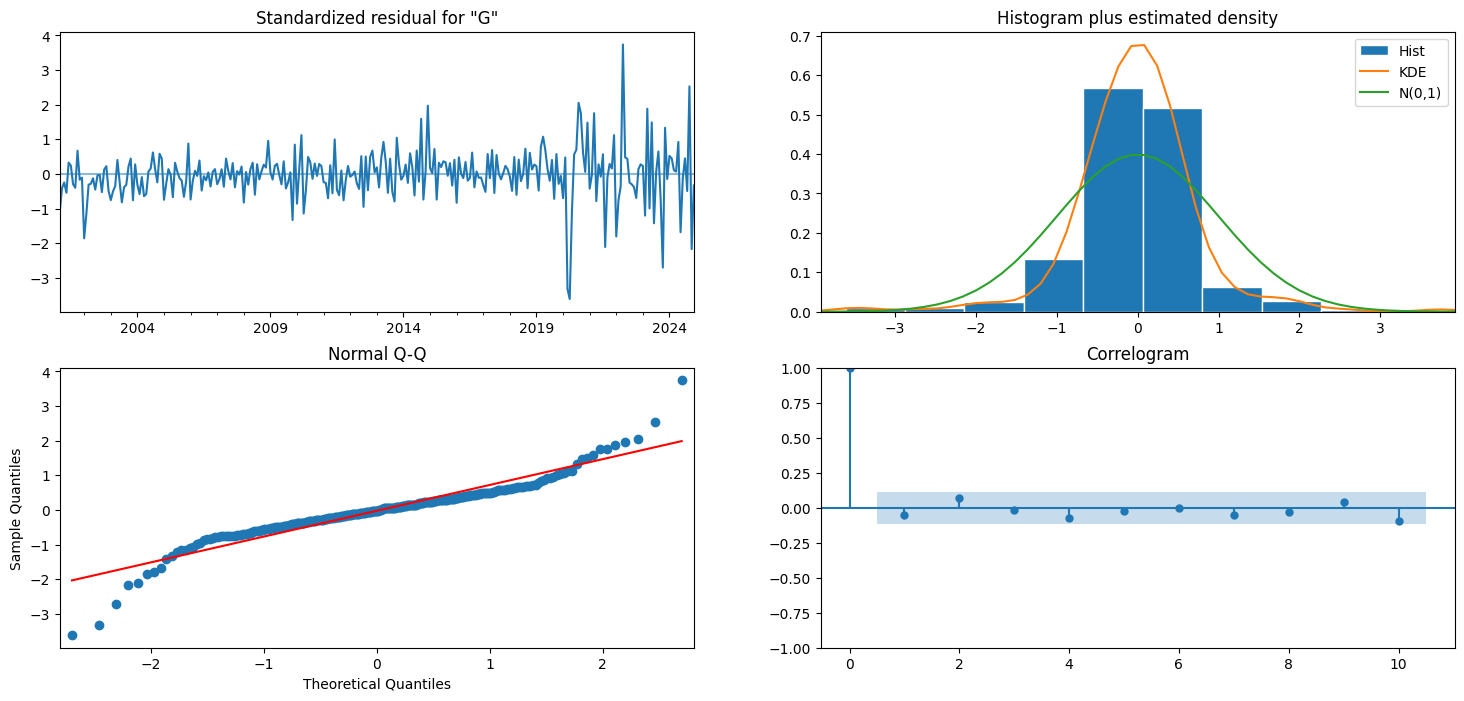

In [320]:
modelos['SARIMA_011'].plot_diagnostics(figsize=(18, 8))
plt.show()
modelos['SARIMA_111'].plot_diagnostics(figsize=(18, 8))
plt.show()


In [336]:
# Asegurar que el índice tenga frecuencia mensual
serie.index = pd.to_datetime(serie.index)
serie = serie.asfreq('MS')

# Fechas a predecir
pred_fechas = pd.date_range(start='2025-01-01', end='2025-05-01', freq='MS')

# Número de pasos de predicción
n_steps = len(pred_fechas)

# Predicción
pred_sarima = modelos['SARIMA_011'].get_forecast(steps=n_steps)
predicciones = pred_sarima.predicted_mean
predicciones.index = pred_fechas



In [338]:
predicciones

2025-01-01    714874.651757
2025-02-01    690581.415858
2025-03-01    726737.229314
2025-04-01    675873.931127
2025-05-01    694258.148337
Freq: MS, Name: predicted_mean, dtype: float64

In [339]:
consumo_real 

Fecha
2025-01-01    645188.60
2025-02-01    686641.50
2025-03-01    796513.62
2025-04-01    643476.90
2025-05-01    747443.53
NaT                 NaN
NaT                 NaN
NaT                 NaN
NaT                 NaN
NaT                 NaN
Name: Gasolina superior, dtype: float64

In [340]:
consumoPred_super_ts.dropna()
consumo_real = consumoPred_super_ts['Gasolina superior']  # Ahora es una Series

comparacion = pd.DataFrame({
    'Predicción SARIMA': predicciones,
    'Valor real': consumo_real
})
comparacion.dropna()
comparacion['Error %'] = (comparacion['Predicción SARIMA']-comparacion["Valor real"])/comparacion["Valor real"]*100
comparacion.dropna()



Predicción SARIMA  Valor real    Error %
2025-01-01      714874.651757   645188.60  10.800881
2025-02-01      690581.415858   686641.50   0.573795
2025-03-01      726737.229314   796513.62  -8.760226
2025-04-01      675873.931127   643476.90   5.034684
2025-05-01      694258.148337   747443.53  -7.115639

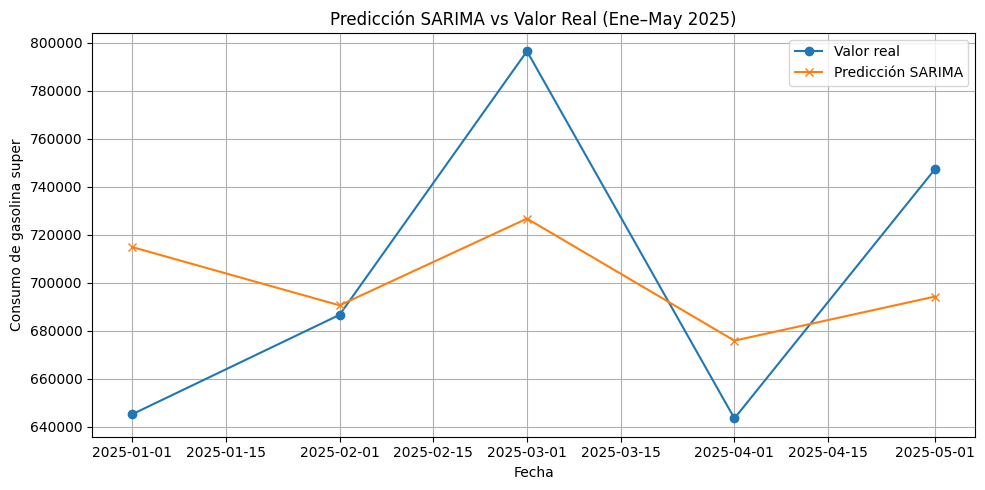

In [341]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(comparacion.index, comparacion['Valor real'], label='Valor real', marker='o')
plt.plot(comparacion.index, comparacion['Predicción SARIMA'], label='Predicción SARIMA', marker='x')
plt.title('Predicción SARIMA vs Valor Real (Ene–May 2025)')
plt.xlabel('Fecha')
plt.ylabel('Consumo de gasolina super')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

En este caso las predicciones fueron más cercanas a la realidad con un error porcentual menor al 11% para cada mes

## Disiel
### Consumo

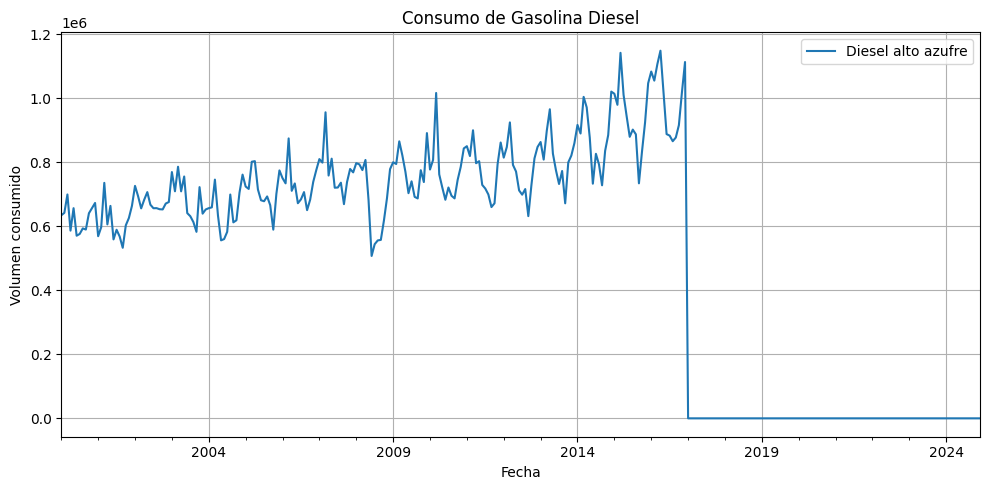

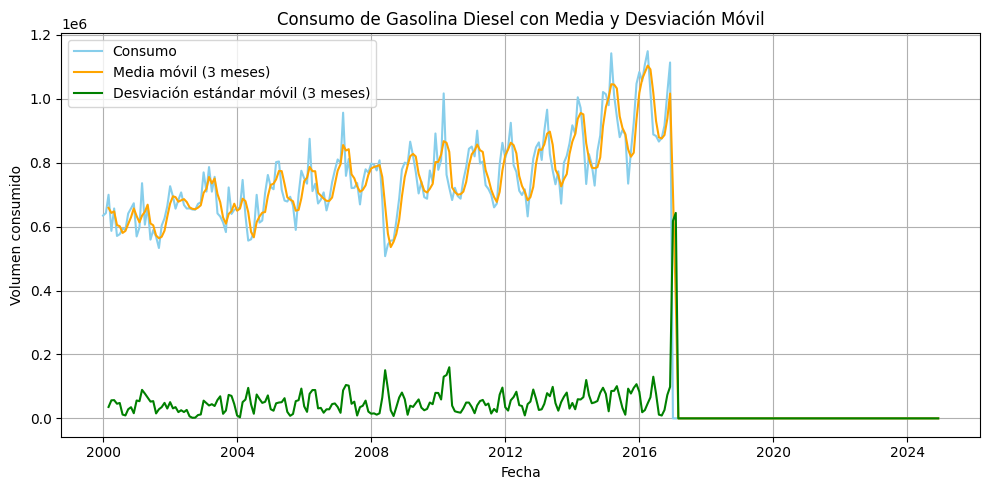

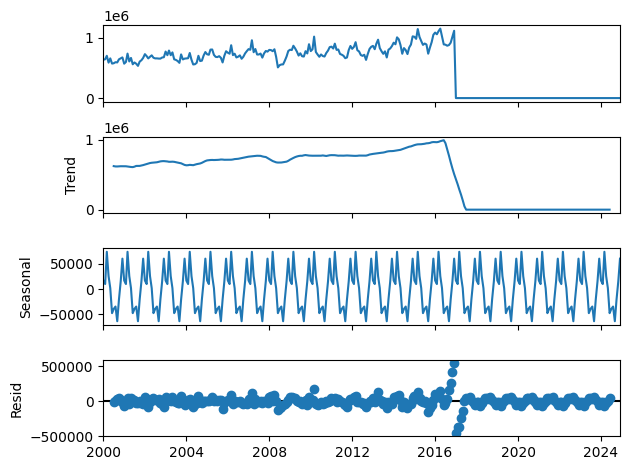

In [181]:

consumos_diesel_ts.plot(figsize=(10, 5), title='Consumo de Gasolina Diesel')
plt.xlabel("Fecha")
plt.ylabel("Volumen consumido")
plt.grid(True)
plt.tight_layout()
plt.show()
media_movil = consumos_diesel_ts.rolling(window=3).mean()
desviacion_movil = consumos_diesel_ts.rolling(window=3).std()



plt.figure(figsize=(10, 5))
plt.plot(consumos_diesel_ts, label='Consumo', color='skyblue')
plt.plot(media_movil, label='Media móvil (3 meses)', color='orange')
plt.plot(desviacion_movil, label='Desviación estándar móvil (3 meses)', color='green')

plt.title('Consumo de Gasolina Diesel con Media y Desviación Móvil')
plt.xlabel('Fecha')
plt.ylabel('Volumen consumido')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Descomponer la serie de tiempo
descomposicion = seasonal_decompose(consumos_diesel_ts, model='additive')

# Graficar la descomposición (tendencia, estacionalidad, residuo)
descomposicion.plot()
plt.tight_layout()
plt.show()

A partir de esas graficas podemos notar:

    - La media tiene cierta tendencia a la alza y luego se anula
    - La grafica de estacionalidad tiene patrones repetitivos lo que parece indicar que esta serie de tiempo tiene estacionalidad
    - La varianza aparenta cierto patron ocilatorio en especial a partir de 2012

Estimar los parámetros del modelo

La grafica anterior nos sugiere que la serie de tiempo para consumo de diesel es estacionaria en varianza

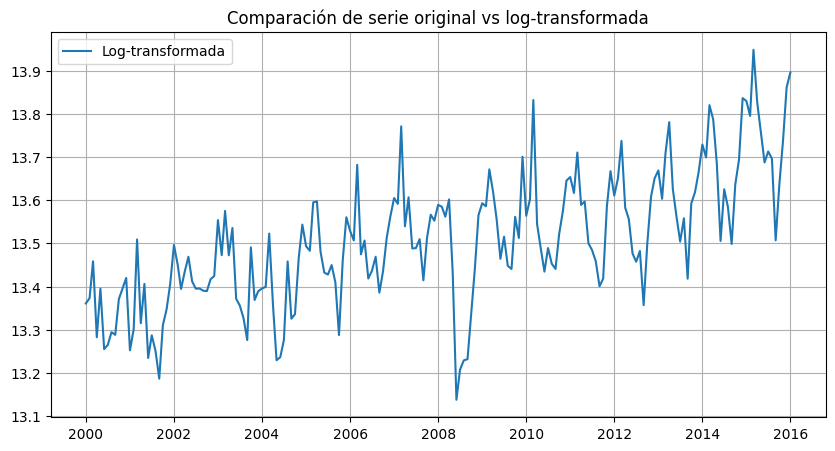

In [186]:
consumos_diesel_ts_log = np.log(consumos_diesel_ts)
plt.figure(figsize=(10, 5))
#plt.plot(consumos_diesel_ts, label='Original')
plt.plot(consumos_diesel_ts_log, label='Log-transformada')
plt.title("Comparación de serie original vs log-transformada")
plt.legend()
plt.grid(True)
plt.show()

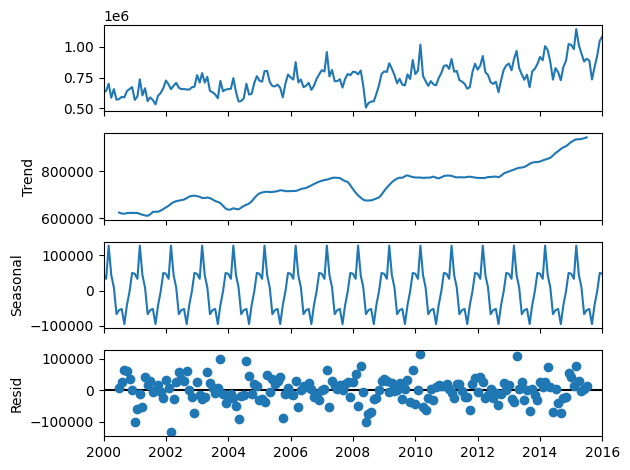

In [184]:
# Filtrar la serie a partir de enero de 2016
consumos_diesel_ts = consumos_diesel_ts[consumos_diesel_ts.index <= '2016-01']

descomposicion = seasonal_decompose(series, model='additive')

# Graficar la descomposición (tendencia, estacionalidad, residuo)
descomposicion.plot()
plt.tight_layout()
plt.show()

Parece que con una transformacion logarithmica la serie de tiempo se quedo con varianza estacionaria.  

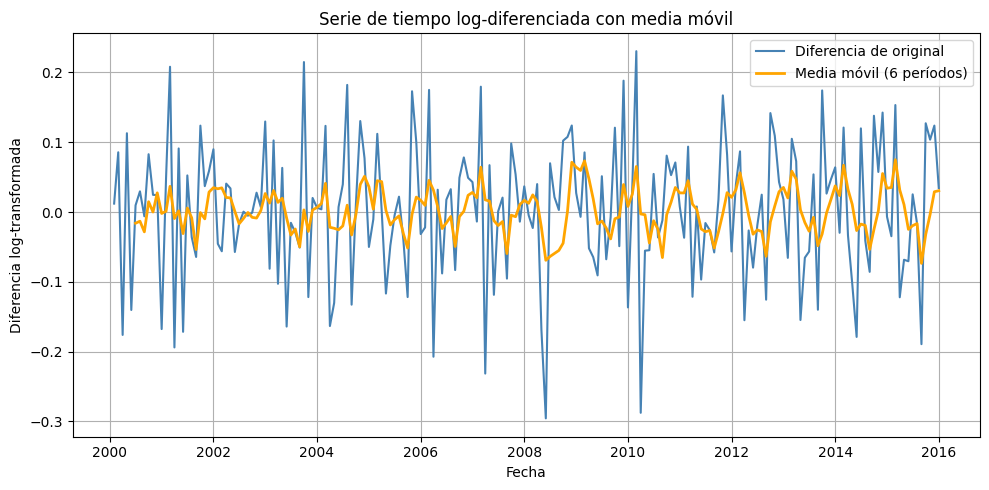

Resultados del Test de Dickey Fuller
Estadístico de prueba       -5.711534e+00
p-value                      7.280578e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    1.800000e+02
Critical Value (1%)         -3.467211e+00
Critical Value (5%)         -2.877735e+00
Critical Value (10%)        -2.575403e+00
dtype: float64


In [187]:
consumos_diesel_ts_diff = consumos_diesel_ts_log.diff().dropna()

media_movil = consumos_diesel_ts_diff.rolling(window=6).mean()

plt.figure(figsize=(10, 5))
plt.plot(consumos_diesel_ts_diff, label='Diferencia de original', color='steelblue')
plt.plot(media_movil, label='Media móvil (6 períodos)', color='orange', linewidth=2)

plt.title("Serie de tiempo log-diferenciada con media móvil")
plt.xlabel("Fecha")
plt.ylabel("Diferencia log-transformada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumos_diesel_ts_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

El p-valor de la prueba de Dickey Fuller es menor a 0.001, por lo que se puede concluir que la serie de tiempo de diesel transformada aoura tiene media estacionaria.

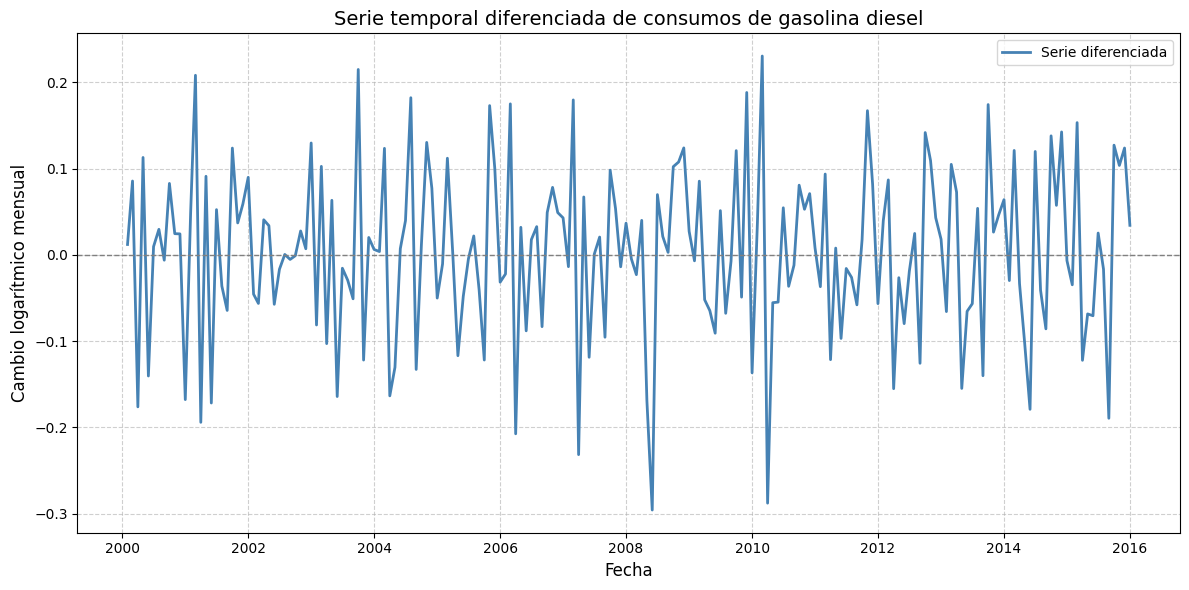

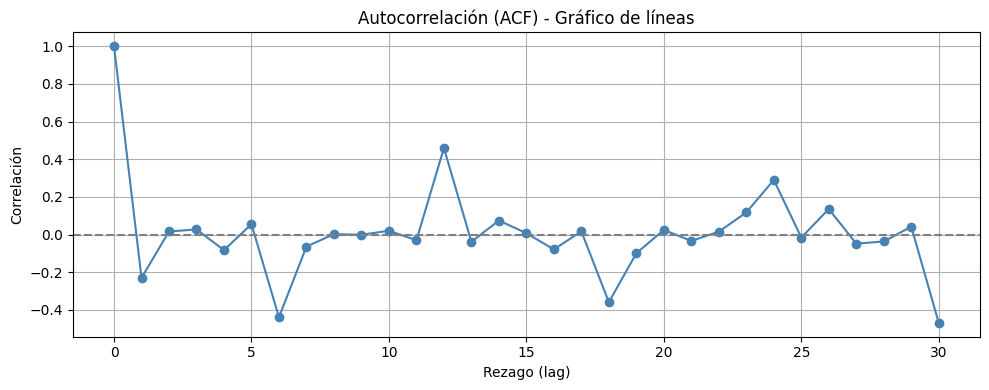

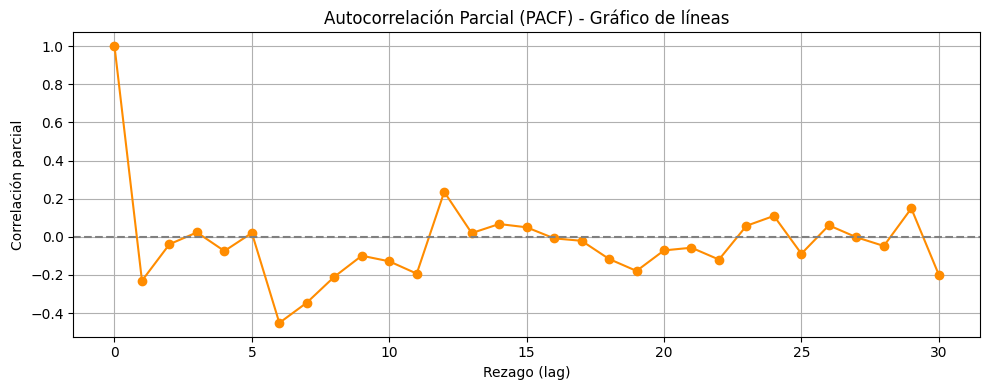

In [191]:
plt.figure(figsize=(12, 6))
plt.plot(consumos_diesel_ts_diff, label='Serie diferenciada', color='steelblue', linewidth=2)

# Mejoras visuales
plt.title('Serie temporal diferenciada de consumos de gasolina diesel', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cambio logarítmico mensual', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # línea base
plt.legend()
plt.tight_layout()
plt.show()


# Asegúrate de no tener nulos
serie = consumos_diesel_ts_diff.dropna()

# Calcular valores de ACF y PACF
acf_vals = acf(serie, nlags=30)
pacf_vals = pacf(serie, nlags=30, method='ywm')

# Eje de lags
lags = np.arange(len(acf_vals))

# Graficar ACF
plt.figure(figsize=(10, 4))
plt.plot(lags, acf_vals, marker='o', linestyle='-', color='steelblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación (ACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar PACF
plt.figure(figsize=(10, 4))
plt.plot(lags, pacf_vals, marker='o', linestyle='-', color='darkorange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Autocorrelación Parcial (PACF) - Gráfico de líneas')
plt.xlabel('Rezago (lag)')
plt.ylabel('Correlación parcial')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un MA(q). Podíamos probar varios modelos ARIMA:

p=0, q=1
p=1, q=2

En ambos casos solo es necesaria una diferenciación por lo que d=2


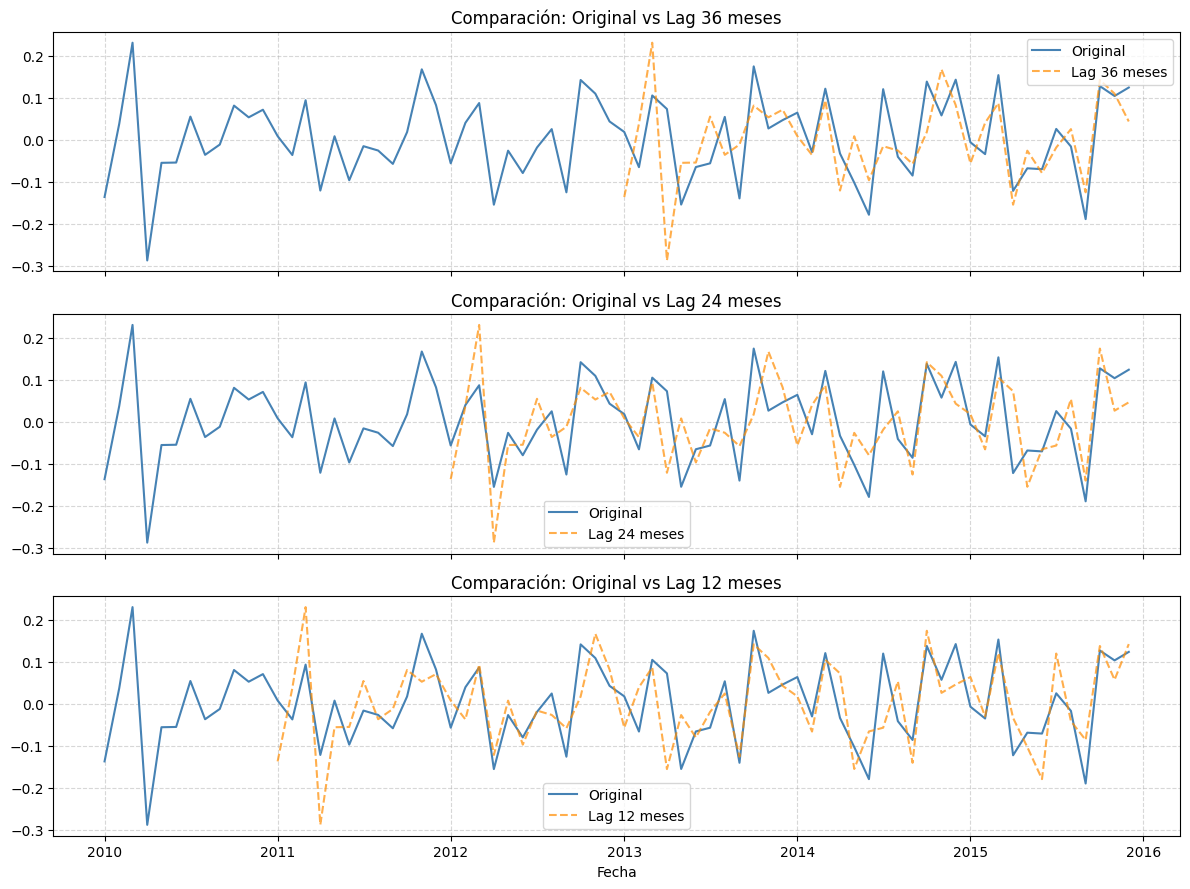

/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: User

       Modelo          AIC          BIC       LogLik
0  SARIMA_011  4450.050610  4459.629480 -2222.025305
1  SARIMA_111  4452.091791  4471.249532 -2220.045895


In [196]:
# Lags a mostrar
lags = [36, 24, 12]

# Recorte visual para que no se sature
serie_base = consumos_diesel_ts_diff['2010':'2015']

fig, axes = plt.subplots(len(lags), 1, figsize=(12, 9), sharex=True)

for i, lag in enumerate(lags):
    axes[i].plot(serie_base, label='Original', color='steelblue')
    axes[i].plot(serie_base.shift(lag), label=f'Lag {lag} meses', color='darkorange', linestyle='--', alpha=0.7)
    axes[i].set_title(f'Comparación: Original vs Lag {lag} meses')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

serie = consumos_diesel_ts.dropna()

# Modelos estacionales SARIMA(p,1,q)(P,1,Q,12)
modelos = {}

#
modelos['SARIMA_011'] = SARIMAX(serie, order=(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)

# SARIMA(2,1,1)(2,1,1,12)
modelos['SARIMA_111'] = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,2,12)).fit(disp=False)


# Crear tabla de comparación
resultados = []

for nombre, modelo in modelos.items():
    resultados.append({
        'Modelo': nombre,
        'AIC': modelo.aic,
        'BIC': modelo.bic,
        'LogLik': modelo.llf
    })

# Mostrar en un DataFrame ordenado por AIC
import pandas as pd

comparacion = pd.DataFrame(resultados).sort_values(by='AIC').reset_index(drop=True)
print(comparacion)


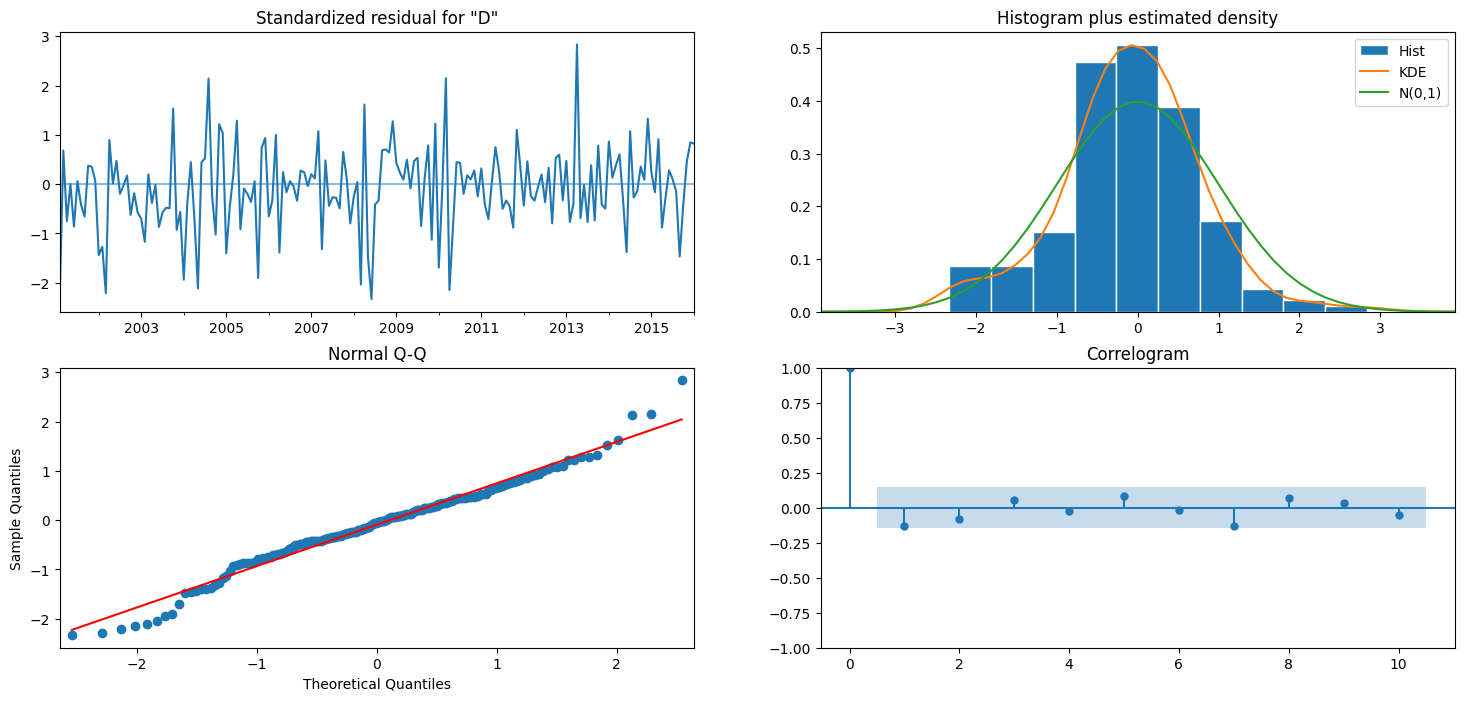

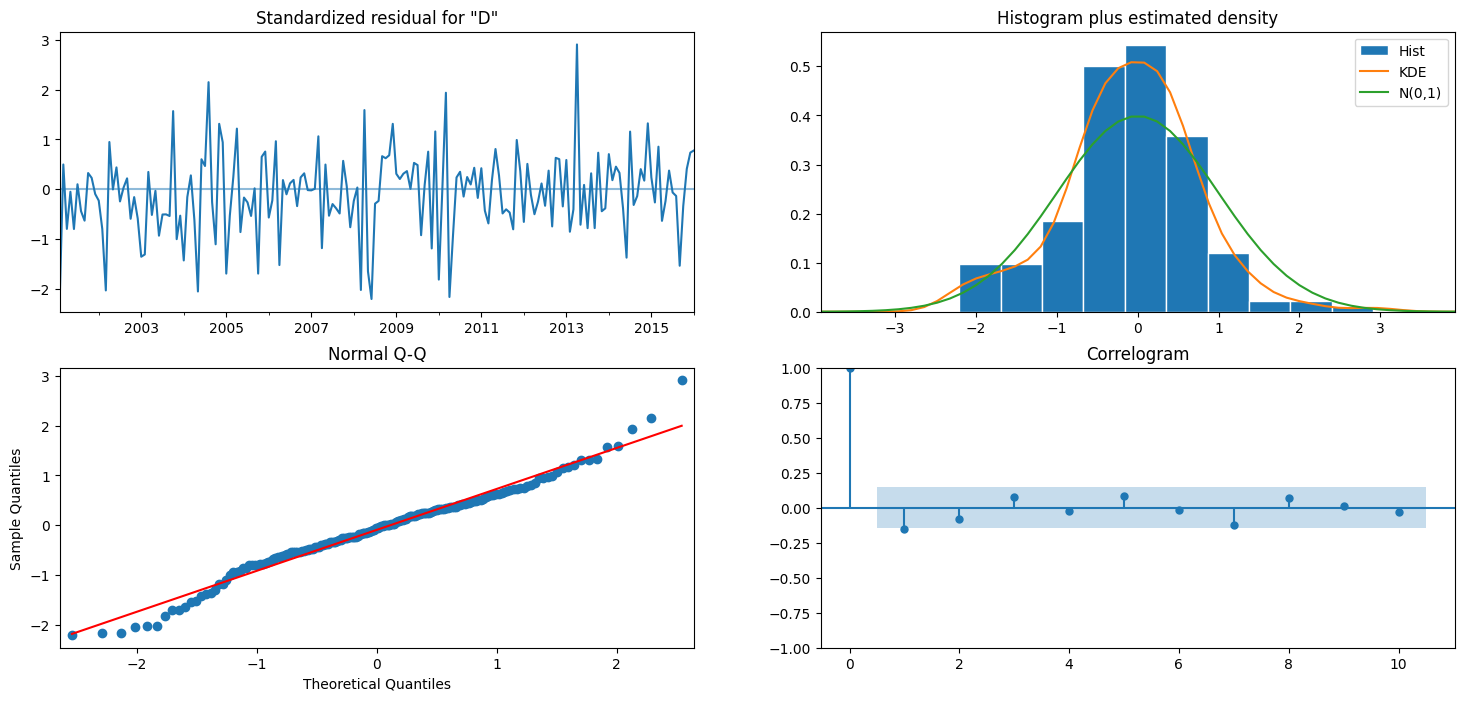

In [197]:
modelos['SARIMA_011'].plot_diagnostics(figsize=(18, 8))
plt.show()
modelos['SARIMA_111'].plot_diagnostics(figsize=(18, 8))
plt.show()


Ambos modelos son muy similares pero el SARIMA_011 parece ser un poco mejor por tener un AIC y un BIC menor al otro modelo

Puesto que en 2016 se dejo de consumir Disel con alto contenido de asufre, hacer predicciones para el 2025 simplemente no tiene setido. 